In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
neehakurelli_google_speech_commands_path = kagglehub.dataset_download('neehakurelli/google-speech-commands')

print('Data source import complete.')


Data source import complete.


In [2]:
# Cell 1: Import necessary libraries
import os
import re
import hashlib
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
from pathlib import Path
import random

# Check and print GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Force TensorFlow to use the first available GPU (if any)
print("TensorFlow Version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    print("GPUs Found:", gpus)
else:
    print("TensorFlow could not find GPUs.")

# Check if we're running on Kaggle and set up paths accordingly
IN_KAGGLE = os.path.exists('/kaggle/input')
if IN_KAGGLE:
    print("Running in Kaggle environment")
else:
    print("Running in local environment")

2025-08-02 11:48:03.929721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754135284.171150      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754135284.236156      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  2
TensorFlow Version: 2.18.0
Num GPUs Available:  2
GPUs Found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Running in Kaggle environment


In [3]:
# Cell 2: Define constants and helper functions
# Constants for the Speech Commands dataset
SAMPLE_RATE = 16000  # Dataset is stored as 16kHz 16-bit PCM WAV files
DURATION = 1.0  # All samples are 1 second in length
N_MFCC = 13  # Number of MFCC features to extract
N_FFT = 2048  # FFT window size
HOP_LENGTH = 512  # Hop length for feature extraction

# We'll focus on these core directional commands as specified
COMMANDS = ["go", "left", "right", "stop"]
N_CLASSES = len(COMMANDS)

# Partitioning percentages as recommended in the README
VAL_PERCENT = 10
TEST_PERCENT = 10
MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M (as defined in the README)

# Function to determine which set a file belongs to (directly from the README)
def which_set(filename, validation_percentage, testing_percentage):
    """Determines which data partition the file should belong to.

    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted
    for example. To keep this stability, a hash of the filename is taken and used
    to determine which set it should belong to.

    Args:
        filename: File path of the data sample.
        validation_percentage: How much of the data set to use for validation.
        testing_percentage: How much of the data set to use for testing.

    Returns:
        String, one of 'training', 'validation', or 'testing'.
    """
    base_name = os.path.basename(filename)
    # We want to ignore anything after '_nohash_' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_nohash_.*$', '', base_name)
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.
    hash_name_hashed = hashlib.sha1(hash_name.encode('utf-8')).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS))
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'testing'
    else:
        result = 'training'
    return result

In [4]:
# Cell 3: Feature extraction function
def extract_features(file_path):
    """Extract MFCC features from an audio file

    This function loads a 1-second audio file and extracts Mel-frequency cepstral
    coefficients (MFCCs), which are commonly used features for speech recognition.
    The audio is first loaded at the correct sample rate (16kHz), then padded if
    shorter than 1 second, and finally the MFCCs are extracted and normalized.

    Args:
        file_path: Path to the audio file

    Returns:
        MFCC features array or None if extraction failed
    """
    try:
        # Load the audio file at the correct sample rate
        audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

        # If audio is shorter than 1 second, pad with zeros
        if len(audio) < SAMPLE_RATE:
            audio = np.pad(audio, (0, SAMPLE_RATE - len(audio)))

        # Extract MFCCs using librosa
        mfccs = librosa.feature.mfcc(
            y=audio,
            sr=SAMPLE_RATE,
            n_mfcc=N_MFCC,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH
        )

        # Normalize MFCCs to have zero mean and unit variance
        mfccs = (mfccs - np.mean(mfccs)) / (np.std(mfccs) + 1e-8)

        return mfccs
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

In [5]:
# Cell 4: Function for adding background noise
def add_background_noise(audio, noise_files, noise_level=0.1):
    """Add background noise to an audio sample

    This function randomly selects a background noise file and adds it to
    the original audio at the specified level.

    Args:
        audio: Original audio signal
        noise_files: List of paths to background noise files
        noise_level: Intensity of noise to add (0.0-1.0)

    Returns:
        Audio with background noise added
    """
    if not noise_files:
        return audio

    # Select a random noise file
    noise_file = random.choice(noise_files)

    try:
        # Load noise audio
        noise, _ = librosa.load(noise_file, sr=SAMPLE_RATE)

        # If noise is shorter than audio, repeat it
        if len(noise) < len(audio):
            repetitions = int(np.ceil(len(audio) / len(noise)))
            noise = np.tile(noise, repetitions)

        # If noise is longer than audio, take a random segment
        if len(noise) > len(audio):
            start = random.randint(0, len(noise) - len(audio))
            noise = noise[start:start + len(audio)]

        # Add noise to audio
        noisy_audio = audio + noise_level * noise[:len(audio)]

        # Normalize to prevent clipping
        noisy_audio = noisy_audio / (np.max(np.abs(noisy_audio)) + 1e-8)

        return noisy_audio
    except Exception as e:
        print(f"Error adding noise from {noise_file}: {e}")
        return audio

In [6]:
# Cell 5: Data loading function
def load_client_data(data_dir, commands, client_id, num_clients=10):
    """Load and preprocess data for a specific client

    This function:
    1. Finds all .wav files for the specified commands
    2. Creates a heterogeneous distribution based on client_id
    3. Assigns files to the client based on speaker ID
    4. Splits data into training, validation, and test sets
    5. Extracts MFCC features from each audio file

    Args:
        data_dir: Root directory containing command subdirectories
        commands: List of command words to include
        client_id: ID of the client to load data for
        num_clients: Total number of clients for distribution

    Returns:
        Tuple of ((X_train, y_train), (X_val, y_val), (X_test, y_test))
    """
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    # Try to find background noise directory
    noise_dir = os.path.join(data_dir, '_background_noise_')
    noise_files = []
    if os.path.exists(noise_dir):
        noise_files = [os.path.join(noise_dir, f) for f in os.listdir(noise_dir)
                      if f.endswith('.wav')]
        print(f"Found {len(noise_files)} background noise files")

    # Process each command
    for i, command in enumerate(commands):
        command_dir = os.path.join(data_dir, command)
        if not os.path.exists(command_dir):
            print(f"Warning: Directory for command '{command}' not found at {command_dir}")
            continue

        files = [os.path.join(command_dir, f) for f in os.listdir(command_dir)
                if f.endswith('.wav')]

        print(f"Found {len(files)} files for command '{command}'")

        # Create heterogeneous data distribution based on client_id
        # Each client gets a different distribution to simulate real-world conditions
        if client_id < 3:
            # Clients 0-2: Balanced with different noise levels
            noise_level = 0.05 * (client_id + 1)  # 0.05, 0.10, 0.15
            files = files
        elif client_id < 5:
            # Clients 3-4: More left/right commands
            if command in ["go", "stop"]:
                files = files[:len(files)//2]  # Use fewer go/stop
            noise_level = 0.1
        elif client_id < 8:
            # Clients 5-7: More go/stop commands
            if command in ["left", "right"]:
                files = files[:len(files)//2]  # Use fewer left/right
            noise_level = 0.1
        else:
            # Clients 8-9: Different speaker distribution
            # Use second half of files (likely different speakers)
            files = files[len(files)//2:]
            noise_level = 0.2

        # Extract speaker IDs from filenames to ensure realistic client assignment
        # Since real-world devices would belong to specific users
        speaker_files = {}
        for f in files:
            base_name = os.path.basename(f)
            speaker_id = base_name.split('_')[0]  # Extract speaker ID

            # Deterministic assignment of speakers to clients based on hash
            speaker_hash = int(hashlib.md5(speaker_id.encode()).hexdigest(), 16)
            assigned_client = speaker_hash % num_clients

            if assigned_client == client_id:
                if speaker_id not in speaker_files:
                    speaker_files[speaker_id] = []
                speaker_files[speaker_id].append(f)

        # Flatten the dictionary to get client's files
        client_files = []
        for speaker_id, files in speaker_files.items():
            client_files.extend(files)

        print(f"Assigned {len(client_files)} files of command '{command}' to client {client_id}")

        # Process each file
        for file_path in client_files:
            # Determine which set this file belongs to
            set_name = which_set(file_path, VAL_PERCENT, TEST_PERCENT)

            try:
                # Load audio
                audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

                # Add background noise (if available)
                if noise_files and random.random() < 0.8:  # 80% chance of adding noise
                    audio = add_background_noise(audio, noise_files, noise_level)

                # Extract features
                features = extract_features(file_path)

                if features is not None:
                    if set_name == 'training':
                        X_train.append(features)
                        y_train.append(i)
                    elif set_name == 'validation':
                        X_val.append(features)
                        y_val.append(i)
                    else:  # testing
                        X_test.append(features)
                        y_test.append(i)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue

    # Calculate the time dimension size (ensure it's an integer)
    time_dim = int(DURATION * SAMPLE_RATE // HOP_LENGTH + 1)

    # Convert lists to arrays and reshape for CNN input
    X_train = np.array(X_train)[..., np.newaxis] if X_train else np.empty((0, N_MFCC, time_dim, 1))
    X_val = np.array(X_val)[..., np.newaxis] if X_val else np.empty((0, N_MFCC, time_dim, 1))
    X_test = np.array(X_test)[..., np.newaxis] if X_test else np.empty((0, N_MFCC, time_dim, 1))

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes=N_CLASSES) if y_train else np.empty((0, N_CLASSES))
    y_val = to_categorical(y_val, num_classes=N_CLASSES) if y_val else np.empty((0, N_CLASSES))
    y_test = to_categorical(y_test, num_classes=N_CLASSES) if y_test else np.empty((0, N_CLASSES))

    print(f"Client {client_id} dataset shapes:")
    print(f"  Training: {X_train.shape}, {y_train.shape}")
    print(f"  Validation: {X_val.shape}, {y_val.shape}")
    print(f"  Testing: {X_test.shape}, {y_test.shape}")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [7]:
# Cell 6: Dataset exploration
def explore_dataset(data_dir):
    """Explore the speech commands dataset structure

    This function provides a detailed view of the dataset:
    1. Lists all command directories
    2. Counts files per command
    3. Analyzes a sample audio file
    4. Visualizes waveform and MFCC features
    5. Examines speaker distribution

    Args:
        data_dir: Path to the dataset root directory
    """
    if not os.path.exists(data_dir):
        print(f"Dataset directory {data_dir} not found!")
        return

    print("Exploring dataset directory...")

    # List all subdirectories (commands)
    all_commands = [d for d in os.listdir(data_dir)
                   if os.path.isdir(os.path.join(data_dir, d))]

    print(f"Found {len(all_commands)} command directories:")
    print(all_commands)

    # Count files for our target commands
    for command in COMMANDS:
        if command in all_commands:
            command_dir = os.path.join(data_dir, command)
            files = [f for f in os.listdir(command_dir) if f.endswith('.wav')]
            print(f"Command '{command}': {len(files)} files")

            # Count unique speakers
            speakers = set()
            for f in files:
                speaker_id = f.split('_')[0]
                speakers.add(speaker_id)
            print(f"  Unique speakers: {len(speakers)}")
        else:
            print(f"Command '{command}' not found in dataset!")

    # Check if validation and testing lists exist
    val_list_path = os.path.join(data_dir, 'validation_list.txt')
    test_list_path = os.path.join(data_dir, 'testing_list.txt')

    if os.path.exists(val_list_path):
        with open(val_list_path, 'r') as f:
            val_files = f.readlines()
        print(f"Validation list contains {len(val_files)} files")
    else:
        print("Validation list not found, will use hashing function")

    if os.path.exists(test_list_path):
        with open(test_list_path, 'r') as f:
            test_files = f.readlines()
        print(f"Testing list contains {len(test_files)} files")
    else:
        print("Testing list not found, will use hashing function")

    # Check a sample file for each command
    for command in COMMANDS:
        if command in all_commands:
            command_dir = os.path.join(data_dir, command)
            files = [f for f in os.listdir(command_dir) if f.endswith('.wav')]
            if files:
                sample_file = os.path.join(command_dir, files[0])
                try:
                    audio, sr = librosa.load(sample_file, sr=None)
                    duration = librosa.get_duration(y=audio, sr=sr)
                    print(f"\nSample file: {os.path.basename(sample_file)}")
                    print(f"Duration: {duration:.2f}s, Sample rate: {sr}Hz, Samples: {len(audio)}")

                    # Plot waveform
                    plt.figure(figsize=(10, 4))
                    plt.plot(np.linspace(0, duration, len(audio)), audio)
                    plt.title(f"Waveform for '{command}' command")
                    plt.xlabel("Time (s)")
                    plt.ylabel("Amplitude")
                    plt.tight_layout()
                    plt.show()

                    # Plot MFCC
                    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)
                    plt.figure(figsize=(10, 4))
                    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
                    plt.colorbar(format='%+2.0f dB')
                    plt.title(f"MFCC for '{command}' command")
                    plt.tight_layout()
                    plt.show()


                except Exception as e:
                    print(f"Error analyzing sample file: {e}")

In [8]:
# Optional: Pre-compute and save features to disk
def precompute_features(data_dir, commands, output_dir="precomputed_features"):
    """Extract and save MFCC features for all files"""
    os.makedirs(output_dir, exist_ok=True)

    for command in commands:
        command_dir = os.path.join(data_dir, command)
        if not os.path.exists(command_dir):
            continue

        # Create output directory for this command
        cmd_output_dir = os.path.join(output_dir, command)
        os.makedirs(cmd_output_dir, exist_ok=True)

        files = [f for f in os.listdir(command_dir) if f.endswith('.wav')]
        print(f"Processing {len(files)} files for command '{command}'...")

        for i, file_name in enumerate(files):
            file_path = os.path.join(command_dir, file_name)
            feature_path = os.path.join(cmd_output_dir, file_name.replace('.wav', '.npy'))

            # Skip if already computed
            if os.path.exists(feature_path):
                continue

            # Extract features
            features = extract_features(file_path)

            if features is not None:
                # Save as numpy file
                np.save(feature_path, features)

            # Show progress
            if (i+1) % 100 == 0:
                print(f"  Processed {i+1}/{len(files)} files")

    print("Feature pre-computation complete!")

# Uncomment to run feature pre-computation (takes time!)
# precompute_features(DATA_DIR, COMMANDS)

In [9]:
# Cell 7: Model definition
def create_model():
    """Create a CNN model for speech command recognition

    This function builds a convolutional neural network designed to classify
    MFCC features extracted from audio commands. The architecture uses two
    convolutional layers for feature extraction followed by dense layers
    for classification.

    Returns:
        A compiled Keras model ready for training
    """
    # Calculate the time dimension size (ensure it's an integer)
    time_dim = int(DURATION * SAMPLE_RATE // HOP_LENGTH + 1)
    input_shape = (N_MFCC, time_dim, 1)

    print(f"Model input shape: {input_shape}")

    # Create the model using the Sequential API
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',
                    input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Block
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(N_CLASSES, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    print("Model architecture created:")
    model.summary()

    return model

# Create a model to see its structure
try:
    model = create_model()
    print("Model created successfully!")
except Exception as e:
    print(f"Error creating model: {e}")
    # Try to diagnose the problem
    time_dim = DURATION * SAMPLE_RATE // HOP_LENGTH + 1
    print(f"Calculated time dimension: {time_dim}, type: {type(time_dim)}")

Model input shape: (13, 32, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1754135298.397871      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754135298.398584      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model architecture created:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model created successfully!


In [10]:
# Cell 8: Client class definition (MODIFIED)
class FLClient:
    """Class representing a federated learning client (edge device)"""
    def __init__(self, client_id, data):
        self.client_id = client_id
        self.X_train, self.y_train = data[0]
        self.X_val, self.y_val = data[1]
        self.X_test, self.y_test = data[2]
        try:
             self.model = create_model()
        except ValueError as e:
            print(f"Error creating model for client {client_id}: {e}")
            time_dim = int(DURATION * SAMPLE_RATE // HOP_LENGTH + 1)
            print(f"Expected input shape based on constants: (N_MFCC={N_MFCC}, time_dim={time_dim}, 1)")
            print(f"Data shapes for client {client_id}:")
            print(f"  Train X: {self.X_train.shape if self.X_train is not None and self.X_train.size > 0 else 'Empty'}")
            print(f"  Val X: {self.X_val.shape if self.X_val is not None and self.X_val.size > 0 else 'Empty'}")
            print(f"  Test X: {self.X_test.shape if self.X_test is not None and self.X_test.size > 0 else 'Empty'}")
            raise e

        self.neighbors = []
        self.optimizer_config = tf.keras.optimizers.Adam().get_config()


    def train_local(self, epochs=5):
        """
        Train the model on local data.
        MODIFIED: Returns the final training and validation loss from the last epoch.
        """
        if self.model.optimizer is None:
             print(f"Client {self.client_id}: Compiling model.")
             self.model.compile(loss='categorical_crossentropy',
                               optimizer=tf.keras.optimizers.Adam.from_config(self.optimizer_config),
                               metrics=['accuracy'])

        if self.X_train is None or self.X_train.shape[0] == 0:
            print(f"Client {self.client_id}: No training data. Skipping local training.")
            return None, None # MODIFIED: Return tuple

        # Ensure validation data is present for val_loss tracking
        validation_data = (self.X_val, self.y_val) if self.X_val is not None and self.X_val.shape[0] > 0 else None
        if validation_data is None:
            print(f"Client {self.client_id}: No validation data. Cannot report validation loss.")

        history = self.model.fit(
            self.X_train, self.y_train,
            validation_data=validation_data,
            epochs=epochs, batch_size=32, verbose=0
        )

        # MODIFIED: Extract final loss values from history
        if history and history.history:
            final_train_loss = history.history['loss'][-1]
            # Handle case where there is no validation data
            final_val_loss = history.history['val_loss'][-1] if 'val_loss' in history.history else None
            return final_train_loss, final_val_loss
        return None, None

    def evaluate(self):
        """Evaluate the model on test data"""
        if self.X_test is None or self.X_test.shape[0] == 0:
            print(f"Client {self.client_id}: No test data. Returning zero loss/accuracy.")
            return [0.0, 0.0]

        if self.model.optimizer is None:
             print(f"Client {self.client_id}: Compiling model before evaluation.")
             self.model.compile(loss='categorical_crossentropy',
                               optimizer=tf.keras.optimizers.Adam.from_config(self.optimizer_config),
                               metrics=['accuracy'])
        return self.model.evaluate(self.X_test, self.y_test, verbose=0)

    def get_parameters(self):
        """Get the model parameters (weights)"""
        if not self.model.weights:
            print(f"Warning: Client {self.client_id} model has no weights.")
            return []
        return self.model.get_weights()

    def set_parameters(self, parameters):
        """Set the model parameters (weights)"""
        try:
            self.model.set_weights(parameters)
        except Exception as e:
            print(f"Error setting weights for client {self.client_id}: {e}")
            raise e

    def plot_confusion_matrix(self):
        """Plot confusion matrix for this client's model"""
        if self.X_test is None or self.X_test.shape[0] == 0:
            print(f"Client {self.client_id}: No test data for confusion matrix.")
            return

        y_pred = self.model.predict(self.X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(self.y_test, axis=1)

        cm = confusion_matrix(y_true_classes, y_pred_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=COMMANDS, yticklabels=COMMANDS)
        plt.title(f'Confusion Matrix - Client {self.client_id}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

        report = classification_report(y_true_classes, y_pred_classes,
                                      target_names=COMMANDS, output_dict=True, zero_division=0)
        print(f"Client {self.client_id} Per-class performance:")
        for cmd in COMMANDS:
            if cmd in report:
                print(f"  {cmd}: F1-score = {report[cmd]['f1-score']:.4f}")

    def train_proximal(self, global_model_weights, epochs=5, mu=0.01):
        """
        Train the model with a proximal term (FedProx).
        MODIFIED: Returns the final training and validation loss from the last epoch.
        """
        if self.X_train is None or self.X_train.shape[0] == 0:
            print(f"Client {self.client_id}: No training data. Skipping proximal training.")
            return None, None # MODIFIED: Return tuple

        global_weights_tensors = [tf.constant(w, dtype=tf.float32) for w in global_model_weights]

        def proximal_loss_fn(y_true, y_pred):
            ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
            proximal_term = tf.constant(0., dtype=tf.float32)
            for local_w, global_w_tensor in zip(self.model.trainable_weights, global_weights_tensors):
                 proximal_term += tf.reduce_sum(tf.square(local_w - global_w_tensor))
            total_loss = ce_loss + (mu / 2) * proximal_term
            return total_loss

        optimizer = tf.keras.optimizers.Adam.from_config(self.optimizer_config)
        self.model.compile(loss=proximal_loss_fn,
                          optimizer=optimizer,
                          metrics=['accuracy'])

        validation_data = (self.X_val, self.y_val) if self.X_val is not None and self.X_val.shape[0] > 0 else None
        if validation_data is None:
            print(f"Client {self.client_id}: No validation data. Cannot report validation loss.")

        history = self.model.fit(
            self.X_train, self.y_train,
            validation_data=validation_data,
            epochs=epochs, batch_size=32, verbose=0
        )

        # MODIFIED: Extract final loss values from history
        if history and history.history:
            final_train_loss = history.history['loss'][-1]
            final_val_loss = history.history['val_loss'][-1] if 'val_loss' in history.history else None
            return final_train_loss, final_val_loss
        return None, None

In [11]:
# Cell 9: Server class definition
class FLServer:
    """Class for coordinating federated learning across clients

    The server:
    - Maintains a list of clients
    - Creates the network topology (who communicates with whom)
    - Implements federated learning algorithms
    - Tracks and visualizes performance metrics
    """
    def __init__(self, clients, edge_weights=None):
        self.clients = clients
        self.n_clients = len(clients)
        self.edge_weights = edge_weights or self._compute_edge_weights()
        self.fedavg_history = []
        self.pfedavg_history = []

    def _compute_edge_weights(self, threshold=0.5):
        """Create edge weights based on data similarity between clients

        This function:
        1. Computes pairwise similarity scores between clients
        2. Creates edges between clients with similarity above threshold
        3. Assigns edge weights proportional to similarity scores

        Returns:
            A matrix of edge weights
        """
        weights = np.zeros((self.n_clients, self.n_clients))

        # For each pair of clients
        for i in range(self.n_clients):
            for j in range(i+1, self.n_clients):
                # In a real-world scenario, we would compute a proper similarity metric
                # based on the data distributions. Here we use a simplification:

                # Client similarity decreases with ID difference (proxy for data heterogeneity)
                base_sim = 1.0 - 0.1 * abs(i - j)

                # Clients with similar data distributions (based on our construction in load_client_data)
                # - Clients 0-2 have balanced data with noise
                # - Clients 3-4 have more left/right commands
                # - Clients 5-7 have more go/stop commands
                # - Clients 8-9 have different speaker distributions

                if (i < 3 and j < 3) or (3 <= i < 5 and 3 <= j < 5) or \
                   (5 <= i < 8 and 5 <= j < 8) or (i >= 8 and j >= 8):
                    # Boost similarity for clients in the same group
                    sim_score = base_sim + 0.3
                else:
                    sim_score = base_sim

                # Normalize to [0, 1]
                sim_score = min(max(sim_score, 0.0), 1.0)

                if sim_score > threshold:
                    weights[i, j] = weights[j, i] = sim_score
                    self.clients[i].neighbors.append(j)
                    self.clients[j].neighbors.append(i)

        return weights

    def plot_network(self):
        """Visualize the federated learning network

        Creates a graph visualization showing clients and their connections.
        """
        import networkx as nx

        G = nx.Graph()

        # Add nodes
        for i in range(self.n_clients):
            G.add_node(i)

        # Add edges
        for i in range(self.n_clients):
            for j in self.clients[i].neighbors:
                G.add_edge(i, j, weight=self.edge_weights[i, j])

        # Plot the graph
        plt.figure(figsize=(10, 8))
        pos = nx.spring_layout(G, seed=42)  # For reproducible layout

        # Create node groups for different client types
        node_groups = [
            [i for i in range(self.n_clients) if i < 3],              # Balanced with noise
            [i for i in range(self.n_clients) if 3 <= i < 5],         # More left/right
            [i for i in range(self.n_clients) if 5 <= i < 8],         # More go/stop
            [i for i in range(self.n_clients) if i >= 8]              # Different speakers
        ]

        # Colors for different client groups
        colors = ['lightblue', 'lightgreen', 'salmon', 'purple']

        # Draw nodes by group
        for group_idx, nodes in enumerate(node_groups):
            nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=500,
                                  node_color=colors[group_idx], alpha=0.8)

        # Draw edges with width proportional to weight
        edge_widths = [self.edge_weights[u][v] * 3 for u, v in G.edges()]
        nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7)

        # Draw node labels
        nx.draw_networkx_labels(G, pos, font_size=12)

        # Add legend
        groups = ['Balanced with noise', 'More left/right', 'More go/stop', 'Different speakers']
        patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10)
                  for c in colors]
        plt.legend(patches, groups, loc='upper right')

        plt.title("Federated Learning Network")
        plt.axis('off')
        plt.tight_layout()
        plt.show()





# Cell 10: FLServer class - Federated Learning Algorithms (MODIFIED)
# (This is a continuation of the FLServer class from Cell 9)

    # --- Replacement for the methods inside Cell 10 ---


    def fedavg(self, communication_rounds=10, local_epochs=5):
        """
        Standard Federated Averaging.
        MODIFIED: Tracks and returns training, validation, and test loss/accuracy.
        """
        acc_history, test_loss_history, train_loss_history, val_loss_history = [], [], [], []
    
        for round_num in range(communication_rounds):
            print(f"\n--- FedAvg Round {round_num+1}/{communication_rounds} ---")
    
            client_parameters = [client.get_parameters() for client in self.clients]
            avg_parameters = []
            for param_idx in range(len(client_parameters[0])):
                avg_parameters.append(
                    np.mean([params[param_idx] for params in client_parameters], axis=0)
                )
    
            # Local training and capture local losses
            round_train_losses, round_val_losses = [], []
            for client in self.clients:
                client.set_parameters(avg_parameters)
                train_loss, val_loss = client.train_local(epochs=local_epochs)
                if train_loss is not None: round_train_losses.append(train_loss)
                if val_loss is not None: round_val_losses.append(val_loss)
    
            # Evaluate global model on test sets
            round_evaluations = [client.evaluate() for client in self.clients]
            round_test_losses = [res[0] for res in round_evaluations]
            round_accuracies = [res[1] for res in round_evaluations]
    
            # Aggregate and store histories
            avg_acc = np.mean(round_accuracies)
            avg_test_loss = np.mean(round_test_losses)
            avg_train_loss = np.mean(round_train_losses) if round_train_losses else 0.0
            avg_val_loss = np.mean(round_val_losses) if round_val_losses else 0.0
    
            acc_history.append(avg_acc)
            test_loss_history.append(avg_test_loss)
            train_loss_history.append(avg_train_loss)
            val_loss_history.append(avg_val_loss)
    
            print(f"Round {round_num+1} Averages -> Acc: {avg_acc:.4f}, Test Loss: {avg_test_loss:.4f}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
        return acc_history, test_loss_history, train_loss_history, val_loss_history
    
    def pfedavg(self, communication_rounds=10, local_epochs=5, lambda_reg=0.1):
        """
        Personalized Federated Averaging (GTVMin).
        MODIFIED: Tracks and returns training, validation, and test loss/accuracy.
        """
        acc_history, test_loss_history, train_loss_history, val_loss_history = [], [], [], []
    
        for round_num in range(communication_rounds):
            print(f"\n--- pFedAvg Round {round_num+1}/{communication_rounds} ---")
    
            # Local training and fine-tuning
            round_train_losses, round_val_losses = [], []
            for i, client in enumerate(self.clients):
                # Main local training
                client.train_local(epochs=local_epochs)
    
                # Aggregation from neighbors
                client_params = client.get_parameters()
                neighbor_params = [self.clients[j].get_parameters() for j in client.neighbors]
                weights = [self.edge_weights[i, j] for j in client.neighbors]
    
                if neighbor_params:
                    weights = np.array(weights) / sum(weights)
                    aggregated_params = []
                    for param_idx in range(len(client_params)):
                        neighbor_avg = np.average([p[param_idx] for p in neighbor_params], axis=0, weights=weights)
                        agg_param = (1 - lambda_reg) * client_params[param_idx] + lambda_reg * neighbor_avg
                        aggregated_params.append(agg_param)
                    client.set_parameters(aggregated_params)
    
                # Fine-tuning step and capture losses
                train_loss, val_loss = client.train_local(epochs=1)
                if train_loss is not None: round_train_losses.append(train_loss)
                if val_loss is not None: round_val_losses.append(val_loss)
    
            # Evaluate personalized models on test sets
            round_evaluations = [client.evaluate() for client in self.clients]
            round_test_losses = [res[0] for res in round_evaluations]
            round_accuracies = [res[1] for res in round_evaluations]
    
            # Aggregate and store histories
            avg_acc = np.mean(round_accuracies)
            avg_test_loss = np.mean(round_test_losses)
            avg_train_loss = np.mean(round_train_losses) if round_train_losses else 0.0
            avg_val_loss = np.mean(round_val_losses) if round_val_losses else 0.0
    
            acc_history.append(avg_acc)
            test_loss_history.append(avg_test_loss)
            train_loss_history.append(avg_train_loss)
            val_loss_history.append(avg_val_loss)
    
            print(f"Round {round_num+1} Averages -> Acc: {avg_acc:.4f}, Test Loss: {avg_test_loss:.4f}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
        return acc_history, test_loss_history, train_loss_history, val_loss_history
    
    def pfedavg_v2(self, communication_rounds=10, local_epochs=5, lambda_reg_v2=0.1):
        """
        Personalized FL (Global Interpolation).
        MODIFIED: Tracks and returns training, validation, and test loss/accuracy.
        """
        acc_history, test_loss_history, train_loss_history, val_loss_history = [], [], [], []
    
        for round_num in range(communication_rounds):
            print(f"\n--- pFedAvg V2 Round {round_num+1}/{communication_rounds} ---")
            global_model = self._compute_global_model()
            round_train_losses, round_val_losses = [], []
    
            for client in self.clients:
                train_loss, val_loss = client.train_local(epochs=local_epochs)
                if train_loss is not None: round_train_losses.append(train_loss)
                if val_loss is not None: round_val_losses.append(val_loss)
    
                updated_model = client.get_parameters()
                personalized_model = []
                for local_param, global_param in zip(updated_model, global_model):
                    personalized_param = lambda_reg_v2 * global_param + (1 - lambda_reg_v2) * local_param
                    personalized_model.append(personalized_param)
                client.set_parameters(personalized_model)
    
            # Evaluate personalized models
            round_evaluations = [client.evaluate() for client in self.clients]
            round_test_losses = [res[0] for res in round_evaluations]
            round_accuracies = [res[1] for res in round_evaluations]
    
            # Aggregate and store
            avg_acc = np.mean(round_accuracies)
            avg_test_loss = np.mean(round_test_losses)
            avg_train_loss = np.mean(round_train_losses) if round_train_losses else 0.0
            avg_val_loss = np.mean(round_val_losses) if round_val_losses else 0.0
    
            acc_history.append(avg_acc)
            test_loss_history.append(avg_test_loss)
            train_loss_history.append(avg_train_loss)
            val_loss_history.append(avg_val_loss)
    
            print(f"Round {round_num+1} Averages -> Acc: {avg_acc:.4f}, Test Loss: {avg_test_loss:.4f}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
        return acc_history, test_loss_history, train_loss_history, val_loss_history
    
    def fedprox(self, communication_rounds=10, local_epochs=5, mu=0.01):
        """
        FedProx Algorithm.
        MODIFIED: Tracks and returns training, validation, and test loss/accuracy.
        """
        acc_history, test_loss_history, train_loss_history, val_loss_history = [], [], [], []
        current_global_weights = self._compute_global_model()
        if not current_global_weights: return [], [], [], []
    
        for round_num in range(communication_rounds):
            print(f"\n--- FedProx Round {round_num+1}/{communication_rounds} ---")
            client_parameter_updates = []
            round_train_losses, round_val_losses = [], []
    
            for client in self.clients:
                client.set_parameters(current_global_weights)
                train_loss, val_loss = client.train_proximal(
                    global_model_weights=current_global_weights, epochs=local_epochs, mu=mu
                )
                if train_loss is not None:
                    client_parameter_updates.append(client.get_parameters())
                    round_train_losses.append(train_loss)
                    if val_loss is not None: round_val_losses.append(val_loss)
                else:
                    print(f"Client {client.client_id} did not train, excluding from aggregation.")
    
            if client_parameter_updates:
                new_global_weights = []
                for param_idx in range(len(client_parameter_updates[0])):
                    layer_params = [params[param_idx] for params in client_parameter_updates]
                    new_global_weights.append(np.mean(layer_params, axis=0))
                current_global_weights = new_global_weights
            else:
                print(f"Warning: No clients submitted updates in round {round_num+1}.")
    
            for client in self.clients:
                client.set_parameters(current_global_weights)
    
            # Evaluate global model on test sets
            round_evaluations = [client.evaluate() for client in self.clients]
            round_test_losses = [res[0] for res in round_evaluations] if round_evaluations else [0]
            round_accuracies = [res[1] for res in round_evaluations] if round_evaluations else [0]
    
            # Aggregate and store
            avg_acc = np.mean(round_accuracies)
            avg_test_loss = np.mean(round_test_losses)
            avg_train_loss = np.mean(round_train_losses) if round_train_losses else 0.0
            avg_val_loss = np.mean(round_val_losses) if round_val_losses else 0.0
    
            acc_history.append(avg_acc)
            test_loss_history.append(avg_test_loss)
            train_loss_history.append(avg_train_loss)
            val_loss_history.append(avg_val_loss)
    
            print(f"Round {round_num+1} Averages -> Acc: {avg_acc:.4f}, Test Loss: {avg_test_loss:.4f}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
        return acc_history, test_loss_history, train_loss_history, val_loss_history
    
    def _compute_global_model(self):
        """Compute the global model weights as the average of all client model weights"""
        # This method does not need changes.
        valid_client_parameters = []
        for client in self.clients:
             params = client.get_parameters()
             if params:
                 valid_client_parameters.append(params)
             else:
                 print(f"Warning: Client {client.client_id} returned no parameters. Excluding.")
        if not valid_client_parameters:
            print("Error: No valid client parameters found. Creating dummy model for initial weights.")
            try:
                dummy_model = create_model()
                return dummy_model.get_weights()
            except Exception as e:
                print(f"Failed to create dummy model for initial weights: {e}")
                return []
        global_model_weights = []
        num_layers = len(valid_client_parameters[0])
        for param_idx in range(num_layers):
            try:
                 stacked_params = [params[param_idx] for params in valid_client_parameters]
                 if stacked_params:
                      global_model_weights.append(np.mean(stacked_params, axis=0))
                 else:
                      global_model_weights.append(None)
            except IndexError:
                 print(f"Error: Index {param_idx} out of bounds for client parameters.")
                 return []
        if any(w is None for w in global_model_weights):
             print("Error: Failed to compute weights for all layers.")
             return []
        return global_model_weights

In [12]:
# Cell 11: Visualization functions

def plot_per_command_performance(clients, method_name):
    """Plot per-command performance across clients

    Creates a heatmap showing how well each client performs on each command.

    Args:
        clients: List of client objects
        method_name: Name of the method being visualized (for the title)
    """
    # Calculate F1 scores for each command for each client
    f1_scores = np.zeros((len(clients), len(COMMANDS)))

    for i, client in enumerate(clients):
        y_pred = client.model.predict(client.X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(client.y_test, axis=1)

        report = classification_report(y_true_classes, y_pred_classes,
                                      target_names=COMMANDS, output_dict=True)

        for j, cmd in enumerate(COMMANDS):
            f1_scores[i, j] = report[cmd]['f1-score']

    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(f1_scores, annot=True, fmt='.2f', cmap='YlGnBu',
               xticklabels=COMMANDS, yticklabels=[f'Client {i}' for i in range(len(clients))])
    plt.title(f'Per-Command F1 Scores - {method_name}')
    plt.xlabel('Command')
    plt.ylabel('Client')
    plt.tight_layout()
    plt.savefig(f'{method_name.lower().replace(" ", "_")}_per_command.png')
    plt.show()

Dataset found at /kaggle/input/google-speech-commands
Exploring dataset directory...
Found 31 command directories:
['no', 'two', 'four', 'five', 'nine', 'right', '_background_noise_', 'off', 'yes', 'six', 'dog', 'left', 'bird', 'wow', 'zero', 'eight', 'bed', 'go', 'house', 'tree', 'seven', 'on', 'three', 'one', 'down', 'stop', 'up', 'happy', 'marvin', 'cat', 'sheila']
Command 'go': 2372 files
  Unique speakers: 1182
Command 'left': 2353 files
  Unique speakers: 1180
Command 'right': 2367 files
  Unique speakers: 1194
Command 'stop': 2380 files
  Unique speakers: 1191
Validation list contains 6798 files
Testing list contains 6835 files

Sample file: 97f4c236_nohash_3.wav
Duration: 1.00s, Sample rate: 16000Hz, Samples: 16000


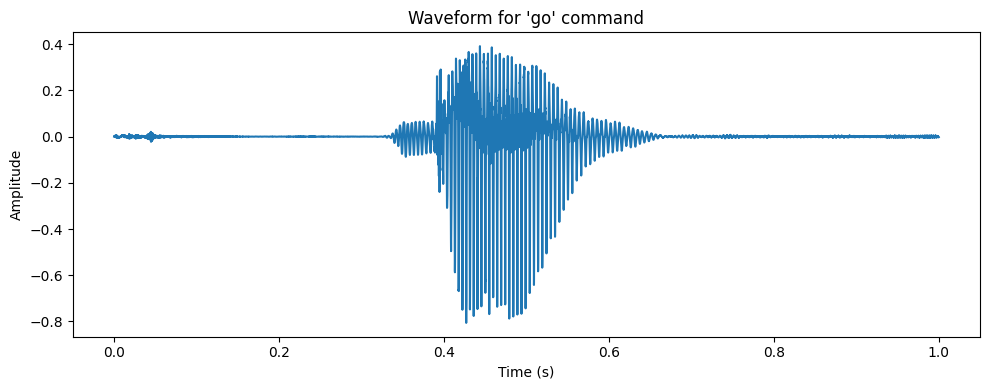

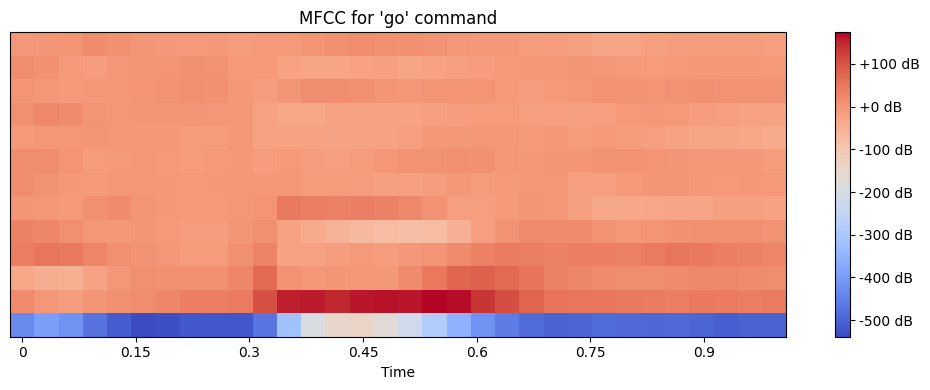


Sample file: 6a700f9d_nohash_0.wav
Duration: 1.00s, Sample rate: 16000Hz, Samples: 16000


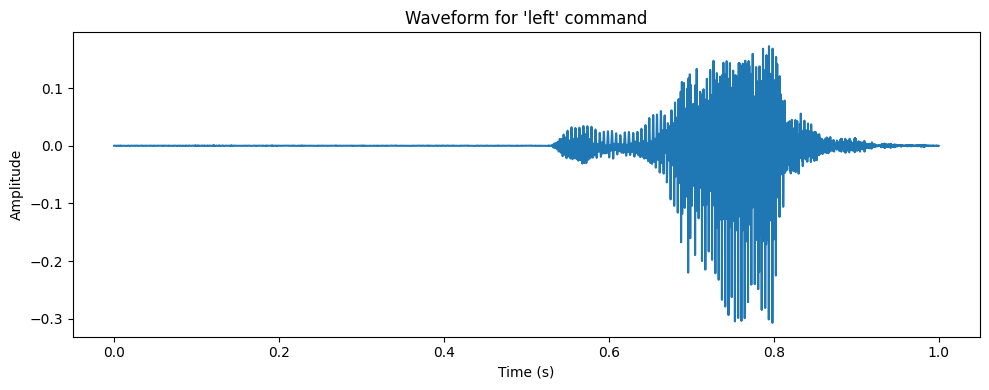

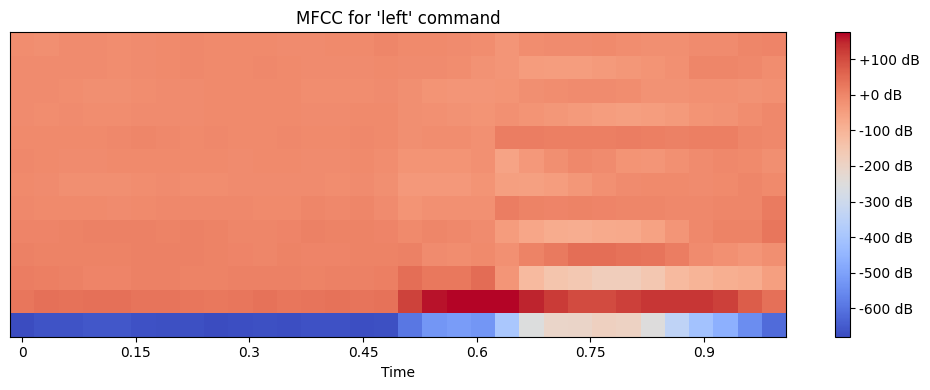


Sample file: 6a700f9d_nohash_0.wav
Duration: 1.00s, Sample rate: 16000Hz, Samples: 16000


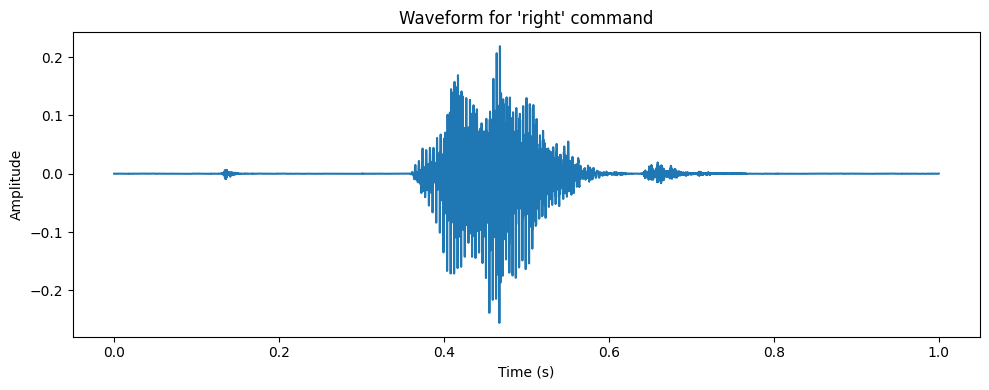

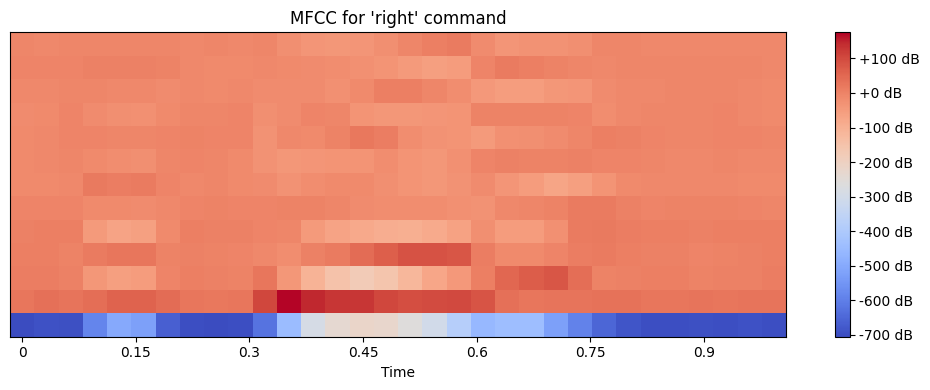


Sample file: 2a89ad5c_nohash_1.wav
Duration: 1.00s, Sample rate: 16000Hz, Samples: 16000


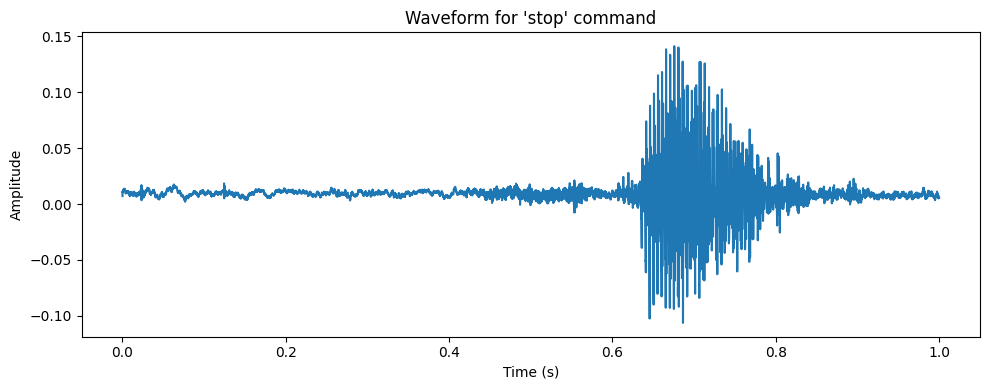

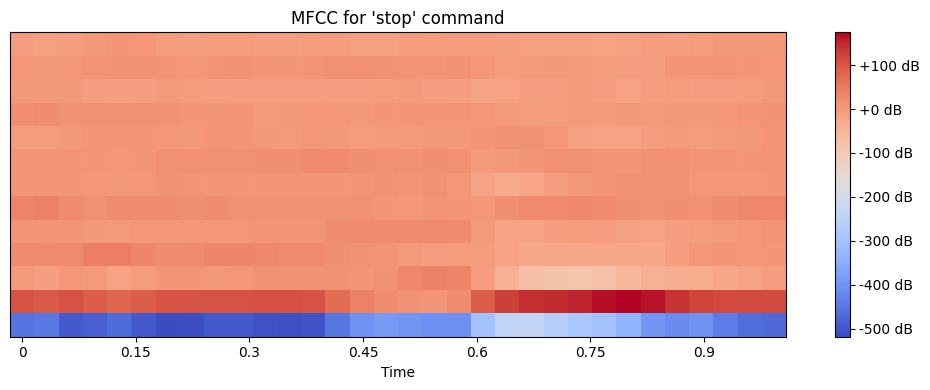

In [13]:
# Cell 12: Setup and dataset preparation
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to the dataset - adjust for Kaggle
if IN_KAGGLE:
    # Path if running in Kaggle (adjust according to your dataset location)
    # Assuming the dataset is extracted to the working directory by kagglehub
    DATA_DIR = neehakurelli_google_speech_commands_path
else:
    # Local path
    DATA_DIR = "./data/speech_commands"

# Check if dataset exists
if not os.path.exists(DATA_DIR):
    print(f"Error: Dataset directory {DATA_DIR} not found!")
else:
    print(f"Dataset found at {DATA_DIR}")
    # Optional: Explore the dataset structure
    explore_dataset(DATA_DIR)

# Cell 13: Load data for clients
def prepare_client_data(data_dir, n_clients=10):
    """Prepare data for all clients

    Loads and preprocesses data for each simulated client.

    Args:
        data_dir: Path to the dataset
        n_clients: Number of clients to simulate

    Returns:
        List of client datasets (each containing train, val, test data)
    """
    client_data = []

    for i in range(n_clients):
        print(f"\nPreparing data for client {i}...")
        data = load_client_data(data_dir, COMMANDS, i, n_clients)
        client_data.append(data)

    return client_data

# Load data for all clients
# n_clients = 10
# print(f"\nLoading data for {n_clients} clients...")
# client_data = prepare_client_data(DATA_DIR, n_clients)

In [14]:
# Cell 14: Train standalone models
def train_standalone_models(client_data, epochs=20):
    """Train standalone models for each client

    This establishes a baseline where each client trains independently.

    Args:
        client_data: List of client datasets
        epochs: Number of training epochs

    Returns:
        Tuple of (list of client objects, list of accuracies)
    """
    clients = []
    standalone_accs = []

    for i in range(len(client_data)):
        print(f"\nTraining standalone model for client {i}...")
        client = FLClient(i, client_data[i])
        client.train_local(epochs=epochs)
        _, acc = client.evaluate()
        standalone_accs.append(acc)
        clients.append(client)
        print(f"Client {i} standalone accuracy: {acc:.4f}")

        # Plot confusion matrix
        client.plot_confusion_matrix()

    # Plot per-command performance
    plot_per_command_performance(clients, "Standalone Models")

    return clients, standalone_accs

# Train standalone models
print("\n===== Training Standalone Models =====")
# Using fewer epochs for demonstration purposes
# standalone_clients, standalone_accs = train_standalone_models(client_data, epochs=20)


===== Training Standalone Models =====


In [15]:
# Cell 15: Train with FedAvg (MODIFIED FOR ALL LOSSES)
def run_fedavg(client_data, comm_rounds=10, local_epochs=5):
    """
    Run Federated Averaging.
    MODIFIED: Handles all loss histories.
    """
    clients = [FLClient(i, client_data[i]) for i in range(len(client_data))]
    server = FLServer(clients)
    server.plot_network()

    print("\nTraining with FedAvg...")
    # MODIFIED: Unpack all four histories
    acc_hist, test_loss_hist, train_loss_hist, val_loss_hist = server.fedavg(
        communication_rounds=comm_rounds, local_epochs=local_epochs
    )

    # Get final per-client metrics
    final_evaluations = [client.evaluate() for client in server.clients]
    final_losses = [res[0] for res in final_evaluations]
    final_accs = [res[1] for res in final_evaluations]

    plot_per_command_performance(server.clients, "FedAvg")

    # MODIFIED: Return all collected metrics and histories
    return server.clients, acc_hist, test_loss_hist, train_loss_hist, val_loss_hist, final_accs, final_losses

In [16]:
# Cell 16: Train with pFedAvg (MODIFIED FOR ALL LOSSES)
def run_pfedavg(client_data, comm_rounds=10, local_epochs=5, lambda_reg=0.1):
    """
    Run Personalized Federated Averaging.
    MODIFIED: Handles all loss histories.
    """
    clients = [FLClient(i, client_data[i]) for i in range(len(client_data))]
    server = FLServer(clients)

    print("\nTraining with pFedAvg...")
    # MODIFIED: Unpack all four histories
    acc_hist, test_loss_hist, train_loss_hist, val_loss_hist = server.pfedavg(
        communication_rounds=comm_rounds,
        local_epochs=local_epochs,
        lambda_reg=lambda_reg
    )

    # Get final per-client metrics
    final_evaluations = [client.evaluate() for client in server.clients]
    final_losses = [res[0] for res in final_evaluations]
    final_accs = [res[1] for res in final_evaluations]

    for client in server.clients:
        client.plot_confusion_matrix()
    plot_per_command_performance(server.clients, "pFedAvg")

    # MODIFIED: Return all collected metrics and histories
    return server.clients, acc_hist, test_loss_hist, train_loss_hist, val_loss_hist, final_accs, final_losses

In [17]:
# Cell 17: Train with pFedAvg V2 (MODIFIED FOR ALL LOSSES)
def run_pfedavg_v2(client_data, comm_rounds=10, local_epochs=5, lambda_reg_v2=0.1):
    """
    Run alternative version of Personalized Federated Averaging.
    MODIFIED: Handles all loss histories.
    """
    clients = [FLClient(i, client_data[i]) for i in range(len(client_data))]
    server = FLServer(clients)

    print("\nTraining with pFedAvg V2 (alternative version)...")
    # MODIFIED: Unpack all four histories
    acc_hist, test_loss_hist, train_loss_hist, val_loss_hist = server.pfedavg_v2(
        communication_rounds=comm_rounds,
        local_epochs=local_epochs,
        lambda_reg_v2=lambda_reg_v2
    )

    # Get final per-client metrics
    final_evaluations = [client.evaluate() for client in server.clients]
    final_losses = [res[0] for res in final_evaluations]
    final_accs = [res[1] for res in final_evaluations]

    for client in server.clients:
        client.plot_confusion_matrix()
    plot_per_command_performance(server.clients, "pFedAvg V2")

    # MODIFIED: Return all collected metrics and histories
    return server.clients, acc_hist, test_loss_hist, train_loss_hist, val_loss_hist, final_accs, final_losses

In [18]:
# Cell 18: Train with FedProx (MODIFIED FOR ALL LOSSES)
def run_fedprox(client_data, comm_rounds=10, local_epochs=5, mu=0.01):
    """
    Run FedProx.
    MODIFIED: Handles all loss histories.
    """
    clients = [FLClient(i, client_data[i]) for i in range(len(client_data))]
    server = FLServer(clients)
    server.plot_network()

    print("\nTraining with FedProx...")
    # MODIFIED: Unpack all four histories
    acc_hist, test_loss_hist, train_loss_hist, val_loss_hist = server.fedprox(
        communication_rounds=comm_rounds,
        local_epochs=local_epochs,
        mu=mu
    )

    # Get final per-client metrics
    final_evaluations = [client.evaluate() for client in server.clients]
    final_losses = [res[0] for res in final_evaluations]
    final_accs = [res[1] for res in final_evaluations]

    for client in server.clients:
        client.plot_confusion_matrix()
    plot_per_command_performance(server.clients, "FedProx")

    # MODIFIED: Return all collected metrics and histories
    return server.clients, acc_hist, test_loss_hist, train_loss_hist, val_loss_hist, final_accs, final_losses

In [19]:
# Cell for Visualization and Comparison (MODIFIED FOR ALL LOSSES)

def compare_selected_results(results):
    """
    Compare and visualize results from selected algorithms.
    MODIFIED: Creates plots for training, validation, and test losses.
    """
    algorithms = list(results.keys())
    algorithm_styles = {
        'standalone': {'color': 'gray', 'marker': 's', 'label': 'Standalone'},
        'fedavg': {'color': 'blue', 'marker': 'o', 'label': 'FedAvg'},
        'pfedavg': {'color': 'red', 'marker': '^', 'label': 'pFedAvg'},
        'pfedavg_v2': {'color': 'magenta', 'marker': 'D', 'label': 'pFedAvg V2'},
        'fedprox': {'color': 'green', 'marker': '*', 'label': 'FedProx'}
    }

    first_algo_with_data = next((algo for algo in algorithms if results[algo].get('accuracies')), None)
    if not first_algo_with_data:
        print("Warning: No data found to generate plots.")
        return
    n_clients = len(results[first_algo_with_data]['accuracies'])
    algorithms_with_data = [algo for algo in algorithms if results[algo].get('accuracies')]

    # --- Plot 1: Final Per-Client Test Accuracy ---
    plt.figure(figsize=(14, 7))
    width = 0.8 / len(algorithms_with_data)
    x = np.arange(n_clients)
    for i, algo in enumerate(algorithms_with_data):
        position = x + (i - len(algorithms_with_data) / 2 + 0.5) * width
        style = algorithm_styles.get(algo, {})
        plt.bar(position, results[algo]['accuracies'], width,
                label=style.get('label', algo), color=style.get('color', 'black'))
    plt.ylabel('Test Accuracy')
    plt.title('Final Per-Client Test Accuracy Comparison')
    plt.xticks(x, [f'Client {i}' for i in range(n_clients)])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('fl_accuracy_comparison.png')
    plt.show()

    # --- Plot 2: Accuracy vs. Communication Rounds ---
    plt.figure(figsize=(12, 6))
    for algo in algorithms:
        if results[algo].get('accuracy_history'):
            style = algorithm_styles.get(algo, {})
            history = results[algo]['accuracy_history']
            plt.plot(range(1, len(history) + 1), history, marker=style.get('marker', '.'),
                     color=style.get('color', 'black'), label=style.get('label', algo))
    plt.xlabel('Communication Round')
    plt.ylabel('Average Test Accuracy')
    plt.title('Training Progress: Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('fl_progress_accuracy.png')
    plt.show()

    # --- NEW PLOTS FOR EACH LOSS TYPE ---

    # --- Plot 3: Test Loss vs. Communication Rounds ---
    plt.figure(figsize=(12, 6))
    for algo in algorithms:
        if results[algo].get('test_loss_history'):
            style = algorithm_styles.get(algo, {})
            history = results[algo]['test_loss_history']
            plt.plot(range(1, len(history) + 1), history, marker=style.get('marker', '.'),
                     color=style.get('color', 'black'), label=style.get('label', algo))
    plt.xlabel('Communication Round')
    plt.ylabel('Average Test Loss')
    plt.title('Training Progress: Test Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('fl_progress_test_loss.png')
    plt.show()

    # --- Plot 4: Training Loss vs. Communication Rounds ---
    plt.figure(figsize=(12, 6))
    for algo in algorithms:
        if results[algo].get('train_loss_history'):
            style = algorithm_styles.get(algo, {})
            history = results[algo]['train_loss_history']
            plt.plot(range(1, len(history) + 1), history, marker=style.get('marker', '.'),
                     color=style.get('color', 'black'), label=style.get('label', algo))
    plt.xlabel('Communication Round')
    plt.ylabel('Average Training Loss (from last local epoch)')
    plt.title('Training Progress: Local Training Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('fl_progress_train_loss.png')
    plt.show()

    # --- Plot 5: Validation Loss vs. Communication Rounds ---
    plt.figure(figsize=(12, 6))
    for algo in algorithms:
        if results[algo].get('val_loss_history'):
            style = algorithm_styles.get(algo, {})
            history = results[algo]['val_loss_history']
            plt.plot(range(1, len(history) + 1), history, marker=style.get('marker', '.'),
                     color=style.get('color', 'black'), label=style.get('label', algo))
    plt.xlabel('Communication Round')
    plt.ylabel('Average Validation Loss (from last local epoch)')
    plt.title('Training Progress: Local Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('fl_progress_val_loss.png')
    plt.show()


    # --- Final Summary Tables ---
    print("\n=== Final Average Results ===")
    summary_data = []
    for algo in algorithms_with_data:
        label = algorithm_styles.get(algo, {}).get('label', algo)
        avg_acc = np.mean(results[algo]['accuracies'])
        avg_loss = np.mean(results[algo]['losses'])
        summary_data.append({'Algorithm': label, 'Avg Accuracy': avg_acc, 'Avg Test Loss': avg_loss})
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False, float_format="%.4f"))

    print("\n=== Detailed Per-Client Results ===")
    table_data = {'Client': [f"Client {i}" for i in range(n_clients)]}
    for algo in algorithms_with_data:
        label = algorithm_styles.get(algo, {}).get('label', algo)
        table_data[f"{label} Acc"] = results[algo].get('accuracies', [np.nan] * n_clients)
        table_data[f"{label} Loss"] = results[algo].get('losses', [np.nan] * n_clients)
    results_df = pd.DataFrame(table_data).fillna(np.nan)
    print(results_df.to_string(index=False, float_format="%.4f", na_rep='N/A'))
    results_df.to_csv('fl_detailed_results_comparison.csv', index=False, float_format='%.4f', na_rep='N/A')

    # --- Statistical Tests ---
    print("\n=== Statistical Significance Tests (Accuracy) ===")
    # (This section remains unchanged and should work as intended)
    from scipy import stats
    methods = [(algorithm_styles.get(algo, {}).get('label', algo), results[algo]['accuracies'])
               for algo in algorithms_with_data if results[algo].get('accuracies')]
    valid_methods = [(name, accs) for name, accs in methods if accs and len(accs) > 1]
    for i, (name1, accs1) in enumerate(valid_methods):
        for name2, accs2 in valid_methods[i+1:]:
            if len(accs1) == len(accs2):
                t_stat, p_val = stats.ttest_rel(accs1, accs2)
                print(f"{name1} vs {name2}: t={t_stat:.4f}, p={p_val:.4f}", end='')
                if p_val < 0.05: print(" (Significant)")
                else: print(" (Not Significant)")

In [20]:
# Cell 19: Main Experiment Runner (MODIFIED FOR ALL LOSSES)
def run_experiment(data_dir, algorithms=None, n_clients=10, standalone_epochs=20,
                  fl_rounds=10, local_epochs=5, lambda_reg=0.1, lambda_reg_v2=0.1, mu=0.01):
    """
    Run an experimental pipeline with selectable algorithms.
    MODIFIED: Handles all loss types and histories.
    """
    if algorithms is None:
        algorithms = ['standalone', 'fedavg', 'pfedavg', 'pfedavg_v2', 'fedprox']
    algorithms = [algo.lower() for algo in algorithms]
    results = {}

    print("=== Step 1: Preparing Client Data ===")
    client_data = prepare_client_data(data_dir, n_clients)

    if 'standalone' in algorithms:
        print("\n=== Running Standalone Models ===")
        standalone_clients, _ = train_standalone_models(client_data, epochs=standalone_epochs)
        final_evals = [client.evaluate() for client in standalone_clients]
        standalone_losses = [res[0] for res in final_evals]
        standalone_accs = [res[1] for res in final_evals]
        # MODIFIED: Add placeholders for structural consistency
        results['standalone'] = {
            'clients': standalone_clients,
            'accuracies': standalone_accs,
            'losses': standalone_losses,
            'accuracy_history': None,
            'test_loss_history': None,
            'train_loss_history': None,
            'val_loss_history': None
        }

    if 'fedavg' in algorithms:
        print("\n=== Running Federated Averaging ===")
        # MODIFIED: Unpack all 7 return values
        clients, acc_hist, test_loss_hist, train_loss_hist, val_loss_hist, final_accs, final_losses = run_fedavg(
            client_data, comm_rounds=fl_rounds, local_epochs=local_epochs
        )
        # MODIFIED: Store all new metrics and histories
        results['fedavg'] = {
            'clients': clients,
            'accuracies': final_accs,
            'losses': final_losses,
            'accuracy_history': acc_hist,
            'test_loss_history': test_loss_hist,
            'train_loss_history': train_loss_hist,
            'val_loss_history': val_loss_hist
        }

    if 'pfedavg' in algorithms:
        print("\n=== Running Personalized Federated Averaging ===")
        # MODIFIED: Unpack all 7 return values
        clients, acc_hist, test_loss_hist, train_loss_hist, val_loss_hist, final_accs, final_losses = run_pfedavg(
            client_data, comm_rounds=fl_rounds, local_epochs=local_epochs, lambda_reg=lambda_reg
        )
        # MODIFIED: Store all new metrics and histories
        results['pfedavg'] = {
            'clients': clients,
            'accuracies': final_accs,
            'losses': final_losses,
            'accuracy_history': acc_hist,
            'test_loss_history': test_loss_hist,
            'train_loss_history': train_loss_hist,
            'val_loss_history': val_loss_hist
        }

    if 'pfedavg_v2' in algorithms:
        print("\n=== Running Alternative Personalized Federated Averaging ===")
        # MODIFIED: Unpack all 7 return values
        clients, acc_hist, test_loss_hist, train_loss_hist, val_loss_hist, final_accs, final_losses = run_pfedavg_v2(
            client_data, comm_rounds=fl_rounds, local_epochs=local_epochs, lambda_reg_v2=lambda_reg_v2
        )
        # MODIFIED: Store all new metrics and histories
        results['pfedavg_v2'] = {
            'clients': clients,
            'accuracies': final_accs,
            'losses': final_losses,
            'accuracy_history': acc_hist,
            'test_loss_history': test_loss_hist,
            'train_loss_history': train_loss_hist,
            'val_loss_history': val_loss_hist
        }

    if 'fedprox' in algorithms:
        print("\n=== Running FedProx ===")
        # MODIFIED: Unpack all 7 return values
        clients, acc_hist, test_loss_hist, train_loss_hist, val_loss_hist, final_accs, final_losses = run_fedprox(
            client_data, comm_rounds=fl_rounds, local_epochs=local_epochs, mu=mu
        )
        # MODIFIED: Store all new metrics and histories
        results['fedprox'] = {
            'clients': clients,
            'accuracies': final_accs,
            'losses': final_losses,
            'accuracy_history': acc_hist,
            'test_loss_history': test_loss_hist,
            'train_loss_history': train_loss_hist,
            'val_loss_history': val_loss_hist
        }

    return results

In [21]:
def analyze_heterogeneity_impact(results):
    """Analyze the impact of data heterogeneity on performance

    This function explores how different client types respond to different training approaches.

    Args:
        results: Dictionary with results from run_experiment
    """
    # Group clients by type
    client_groups = {
        'Balanced with noise': [0, 1, 2],
        'More left/right': [3, 4],
        'More go/stop': [5, 6, 7],
        'Different speakers': [8, 9]
    }

    # Define algorithm display names for better readability
    algorithm_names = {
        'standalone': 'Standalone (Local Only)',
        'fedavg': 'FedAvg (Global Model)',
        'pfedavg': 'pFedAvg (Original)',
        'pfedavg_v2': 'pFedAvg V2 (Alternative)',
        'fedprox': 'FedProx'
    }

    # Colors for plotting
    algorithm_colors = {
        'standalone': 'gray',
        'fedavg': 'blue',
        'pfedavg': 'red',
        'pfedavg_v2': 'magenta',
        'fedprox': 'green'
    }

    # Extract accuracies for each group and algorithm
    group_results = {}
    for group_name, client_ids in client_groups.items():
        group_results[group_name] = {}

        for algo_key in results.keys():
            if 'accuracies' in results[algo_key]:
                group_results[group_name][algo_key] = [
                    results[algo_key]['accuracies'][i] for i in client_ids
                ]

    # Plot group-wise performance
    plt.figure(figsize=(14, 8))
    x = np.arange(len(client_groups))
    width = 0.8 / len(results)  # Adjust width based on number of algorithms

    # Plot bars for each algorithm
    for i, (algo_key, algo_data) in enumerate(results.items()):
        if 'accuracies' in algo_data:  # Check if algorithm has accuracy data
            algo_means = [np.mean(group_results[g][algo_key]) for g in client_groups]
            position = [pos + (i - len(results)/2 + 0.5) * width for pos in x]
            plt.bar(position, algo_means, width,
                    label=algorithm_names.get(algo_key, algo_key),
                    color=algorithm_colors.get(algo_key, 'black'))

    plt.ylabel('Average Accuracy')
    plt.title('Impact of Data Heterogeneity on Model Performance')
    plt.xticks(x, client_groups.keys())
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('heterogeneity_impact.png')
    plt.show()

    # Print group-wise results
    print("\n=== Impact of Data Heterogeneity ===")

    for group_name in client_groups:
        print(f"\n{group_name}:")

        # Print accuracy for each algorithm
        for algo_key in results.keys():
            if 'accuracies' in results[algo_key]:
                algo_name = algorithm_names.get(algo_key, algo_key)
                group_acc = np.mean(group_results[group_name][algo_key])
                print(f"  {algo_name}: {group_acc:.4f}")

        # Calculate improvements relative to standalone (if available)
        if 'standalone' in results and 'accuracies' in results['standalone']:
            standalone_acc = np.mean(group_results[group_name]['standalone'])

            print(f"\n  Improvements over Standalone:")
            for algo_key in results.keys():
                if algo_key != 'standalone' and 'accuracies' in results[algo_key]:
                    algo_name = algorithm_names.get(algo_key, algo_key)
                    algo_acc = np.mean(group_results[group_name][algo_key])
                    improvement = algo_acc - standalone_acc
                    print(f"    {algo_name}: {improvement:.4f} ({improvement*100:.1f}%)")

        # Calculate improvements relative to FedAvg (if available)
        if 'fedavg' in results and 'accuracies' in results['fedavg']:
            fedavg_acc = np.mean(group_results[group_name]['fedavg'])

            print(f"\n  Improvements over FedAvg:")
            for algo_key in results.keys():
                if algo_key not in ['standalone', 'fedavg'] and 'accuracies' in results[algo_key]:
                    algo_name = algorithm_names.get(algo_key, algo_key)
                    algo_acc = np.mean(group_results[group_name][algo_key])
                    improvement = algo_acc - fedavg_acc
                    print(f"    {algo_name}: {improvement:.4f} ({improvement*100:.1f}%)")

Starting the full experiment...
=== Step 1: Preparing Client Data ===

Preparing data for client 0...
Found 6 background noise files
Found 2372 files for command 'go'
Assigned 238 files of command 'go' to client 0
Found 2353 files for command 'left'
Assigned 230 files of command 'left' to client 0
Found 2367 files for command 'right'
Assigned 237 files of command 'right' to client 0
Found 2380 files for command 'stop'
Assigned 238 files of command 'stop' to client 0
Client 0 dataset shapes:
  Training: (714, 13, 32, 1), (714, 4)
  Validation: (121, 13, 32, 1), (121, 4)
  Testing: (108, 13, 32, 1), (108, 4)

Preparing data for client 1...
Found 6 background noise files
Found 2372 files for command 'go'
Assigned 254 files of command 'go' to client 1
Found 2353 files for command 'left'
Assigned 230 files of command 'left' to client 1
Found 2367 files for command 'right'
Assigned 243 files of command 'right' to client 1
Found 2380 files for command 'stop'
Assigned 245 files of command 'sto

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1754135485.859044      94 service.cc:148] XLA service 0x7e84b4006020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754135485.859803      94 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754135485.859821      94 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754135486.138883      94 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754135488.689113      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Client 0 standalone accuracy: 0.9259
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


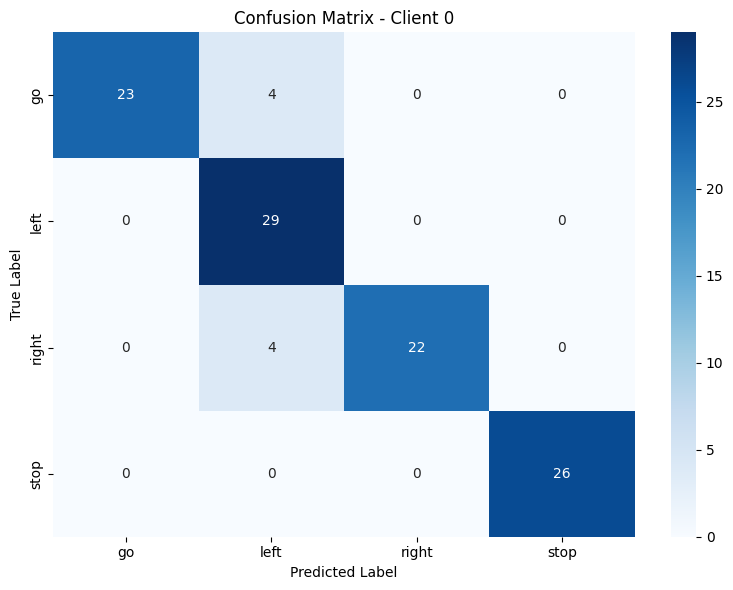

Client 0 Per-class performance:
  go: F1-score = 0.9200
  left: F1-score = 0.8788
  right: F1-score = 0.9167
  stop: F1-score = 1.0000

Training standalone model for client 1...
Model input shape: (13, 32, 1)
Model architecture created:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Client 1 standalone accuracy: 0.7619
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


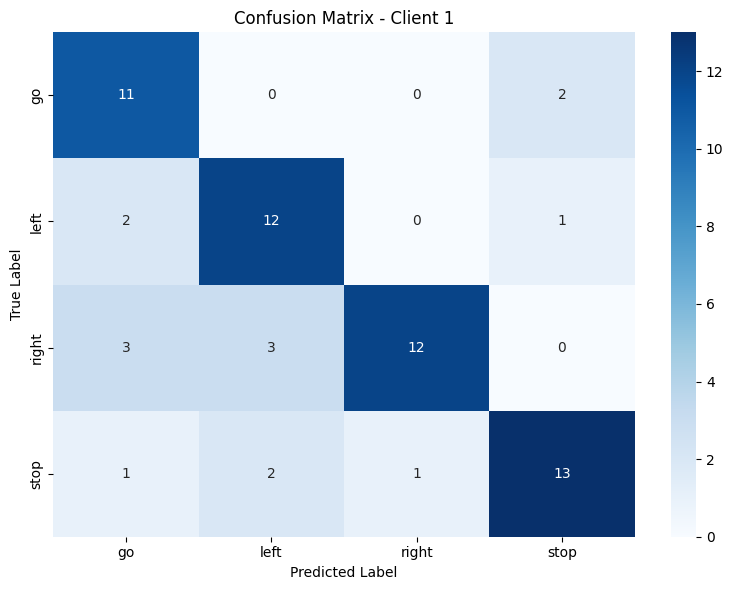

Client 1 Per-class performance:
  go: F1-score = 0.7333
  left: F1-score = 0.7500
  right: F1-score = 0.7742
  stop: F1-score = 0.7879

Training standalone model for client 2...
Model input shape: (13, 32, 1)
Model architecture created:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Client 2 standalone accuracy: 0.8767
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


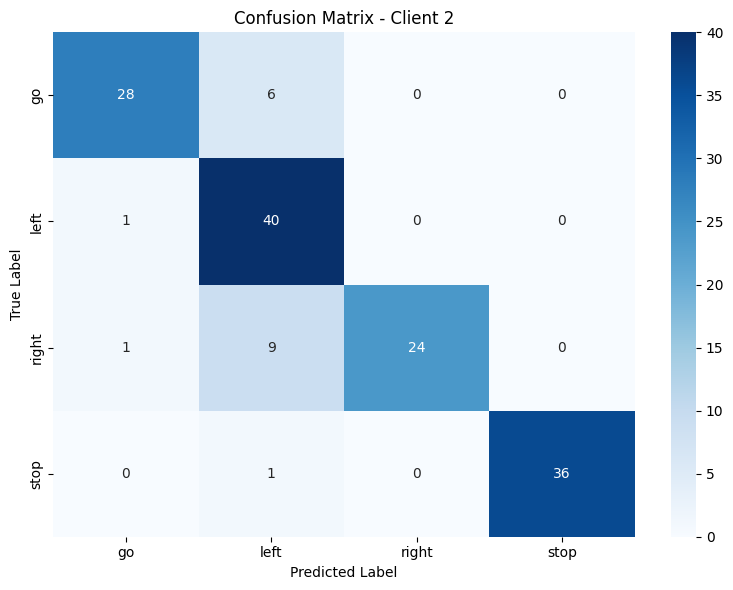

Client 2 Per-class performance:
  go: F1-score = 0.8750
  left: F1-score = 0.8247
  right: F1-score = 0.8276
  stop: F1-score = 0.9863

Training standalone model for client 3...
Model input shape: (13, 32, 1)
Model architecture created:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Client 3 standalone accuracy: 0.7662
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


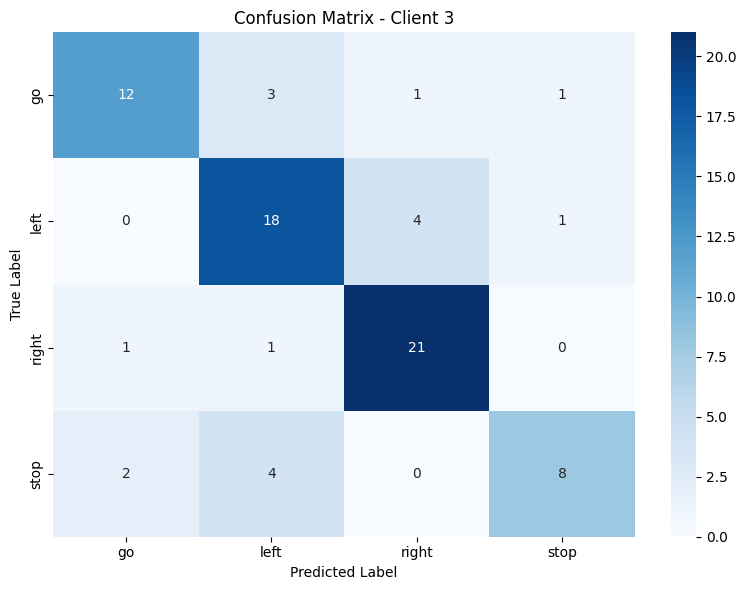

Client 3 Per-class performance:
  go: F1-score = 0.7500
  left: F1-score = 0.7347
  right: F1-score = 0.8571
  stop: F1-score = 0.6667

Training standalone model for client 4...
Model input shape: (13, 32, 1)
Model architecture created:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Client 4 standalone accuracy: 0.8772
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


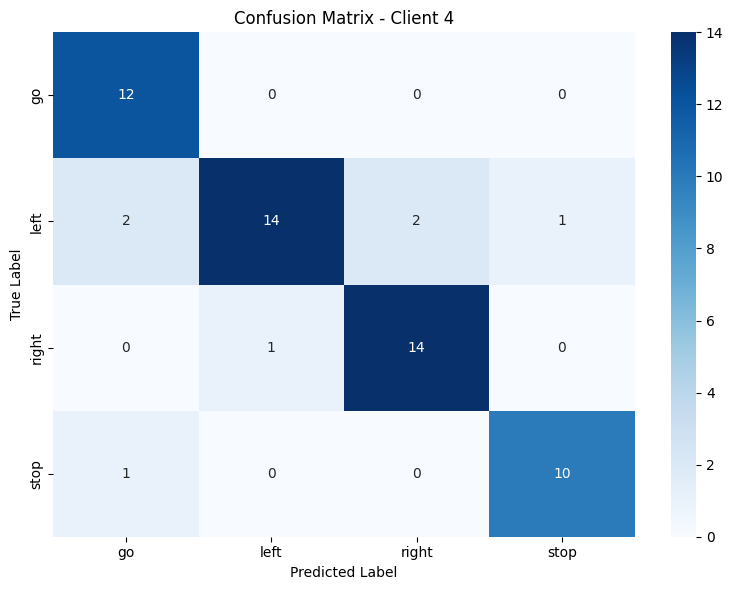

Client 4 Per-class performance:
  go: F1-score = 0.8889
  left: F1-score = 0.8235
  right: F1-score = 0.9032
  stop: F1-score = 0.9091

Training standalone model for client 5...
Model input shape: (13, 32, 1)
Model architecture created:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Client 5 standalone accuracy: 0.8485
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


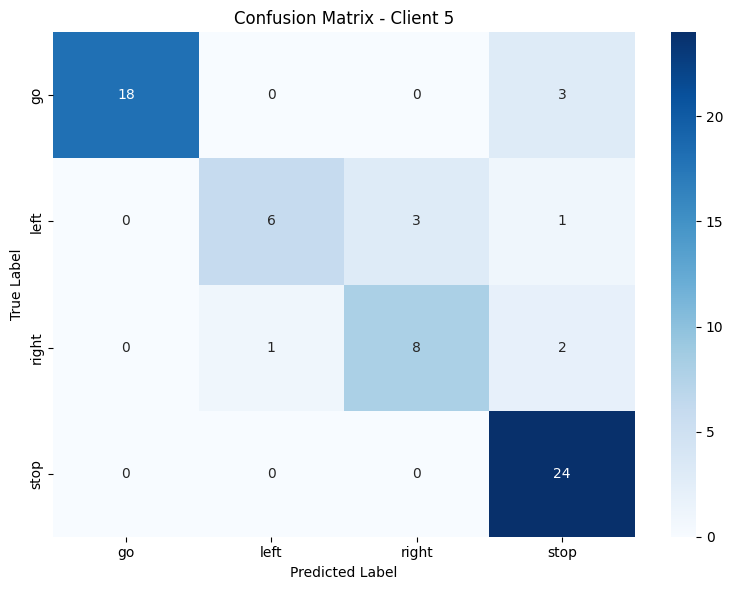

Client 5 Per-class performance:
  go: F1-score = 0.9231
  left: F1-score = 0.7059
  right: F1-score = 0.7273
  stop: F1-score = 0.8889

Training standalone model for client 6...
Model input shape: (13, 32, 1)
Model architecture created:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Client 6 standalone accuracy: 0.8469
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


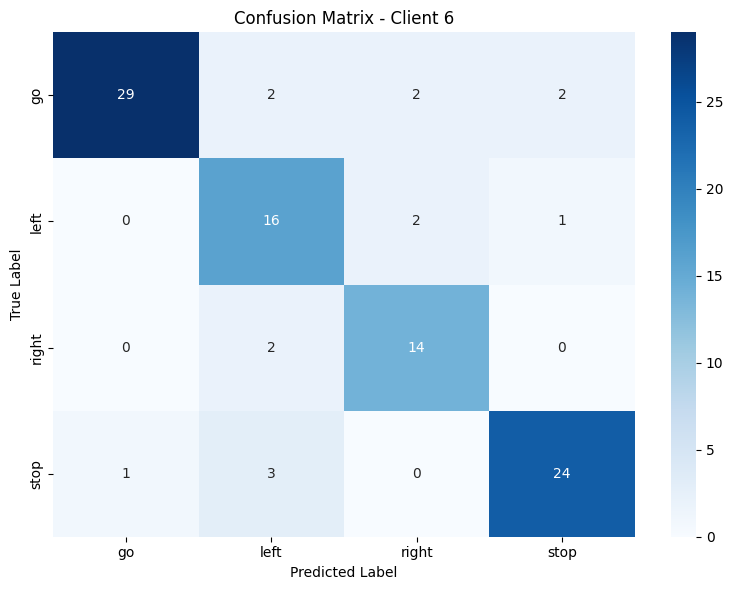

Client 6 Per-class performance:
  go: F1-score = 0.8923
  left: F1-score = 0.7619
  right: F1-score = 0.8235
  stop: F1-score = 0.8727

Training standalone model for client 7...
Model input shape: (13, 32, 1)
Model architecture created:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Client 7 standalone accuracy: 0.8028
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


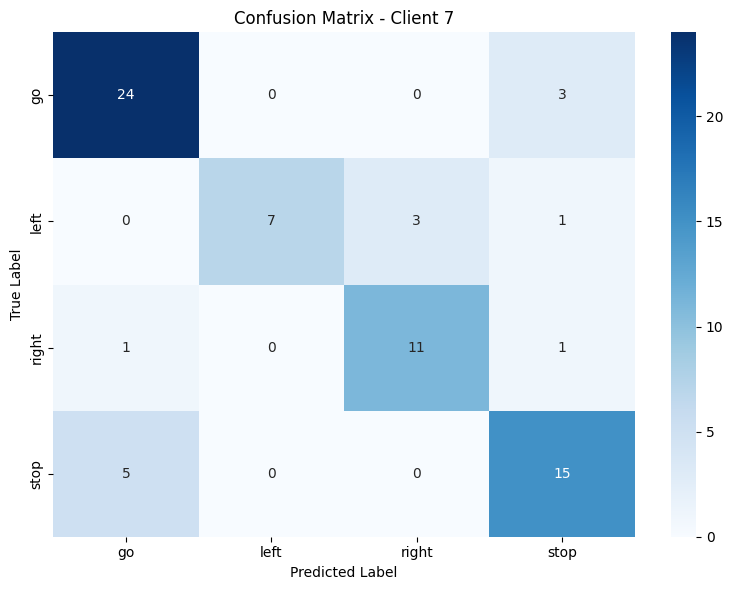

Client 7 Per-class performance:
  go: F1-score = 0.8421
  left: F1-score = 0.7778
  right: F1-score = 0.8148
  stop: F1-score = 0.7500

Training standalone model for client 8...
Model input shape: (13, 32, 1)
Model architecture created:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Client 8 standalone accuracy: 0.7206
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


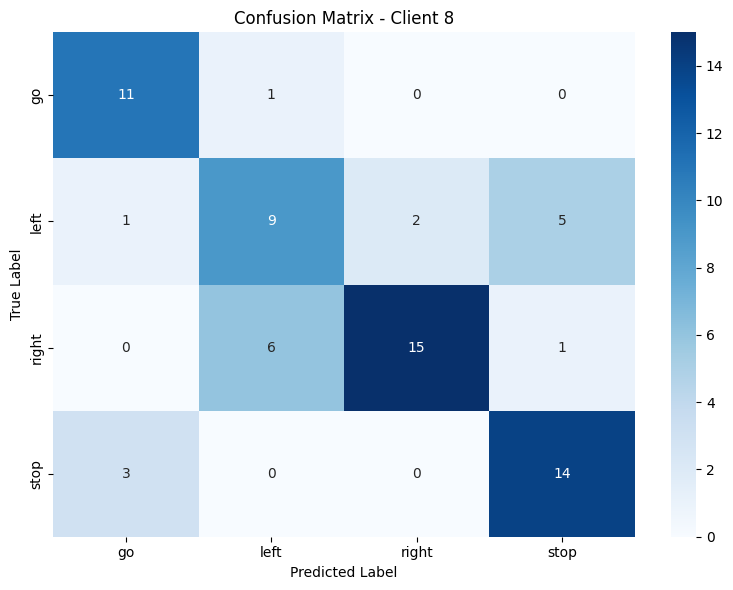

Client 8 Per-class performance:
  go: F1-score = 0.8148
  left: F1-score = 0.5455
  right: F1-score = 0.7692
  stop: F1-score = 0.7568

Training standalone model for client 9...
Model input shape: (13, 32, 1)
Model architecture created:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Client 9 standalone accuracy: 0.7200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


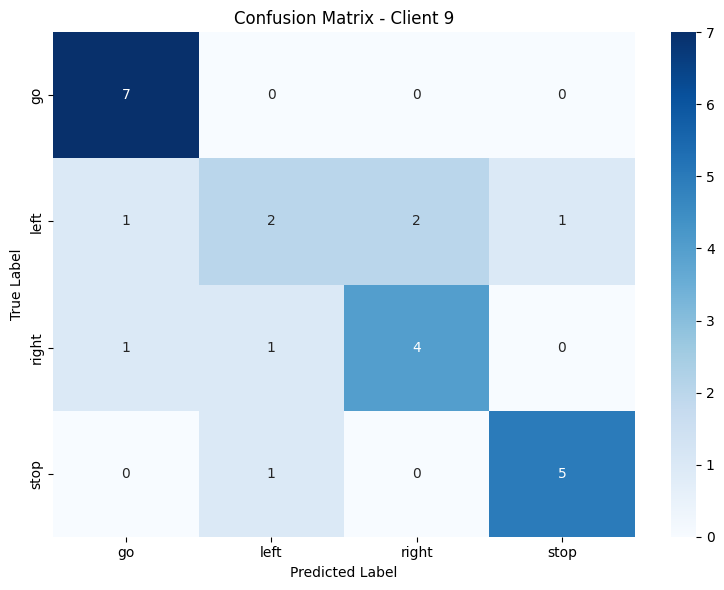

Client 9 Per-class performance:
  go: F1-score = 0.8750
  left: F1-score = 0.4000
  right: F1-score = 0.6667
  stop: F1-score = 0.8333
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


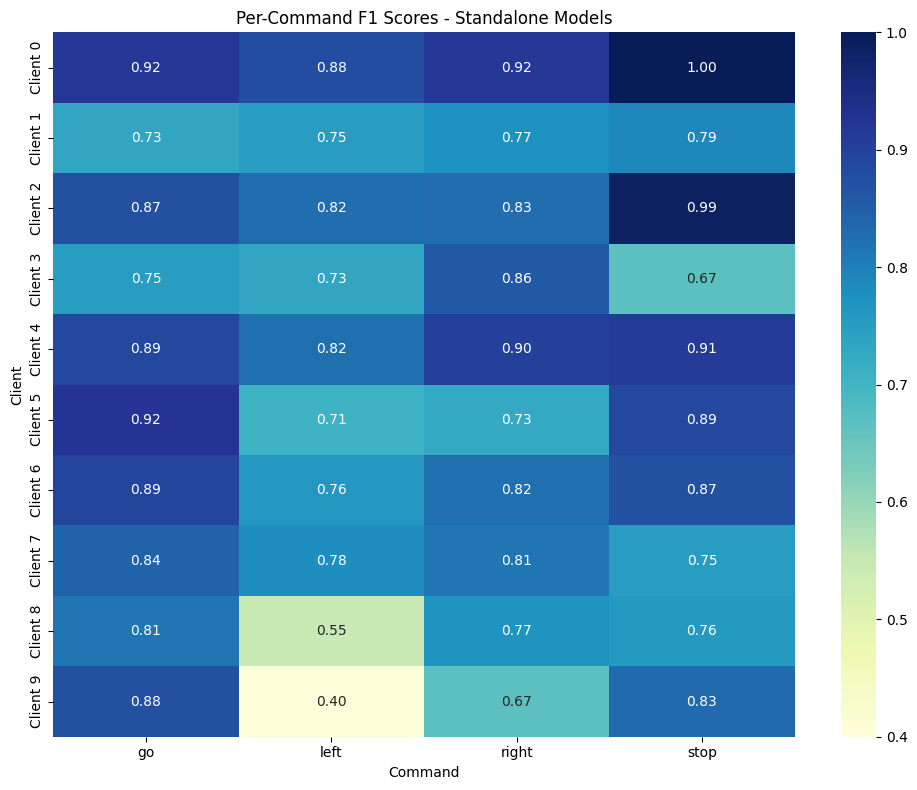


=== Running Federated Averaging ===
Model input shape: (13, 32, 1)
Model architecture created:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

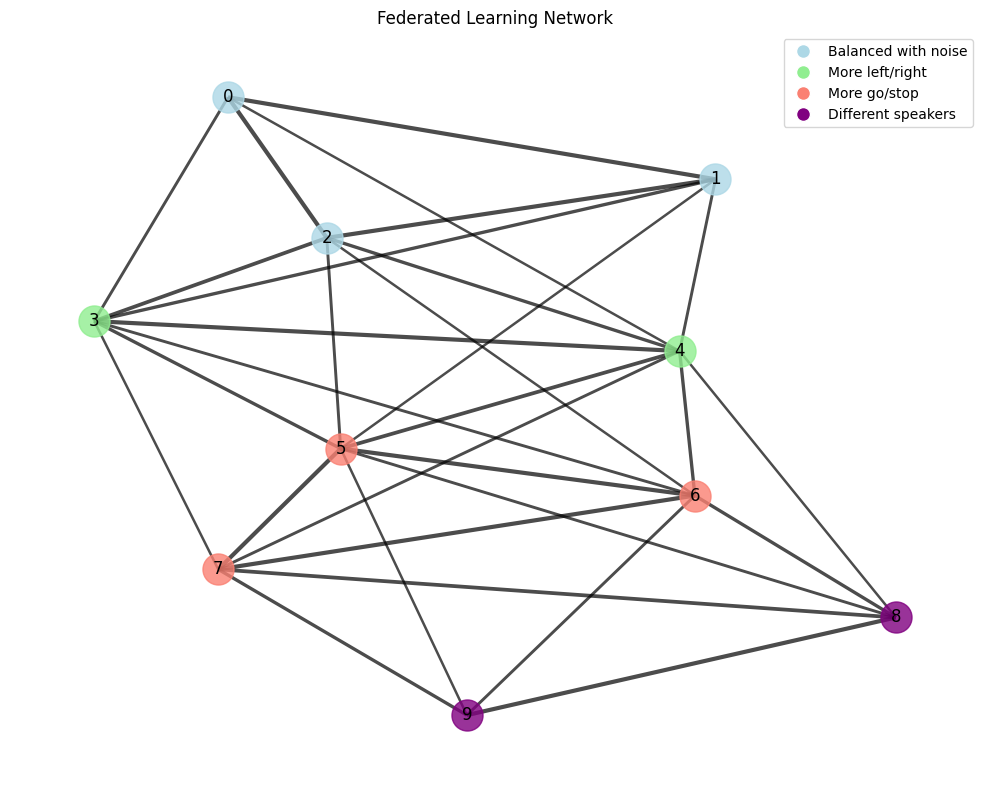


Training with FedAvg...

--- FedAvg Round 1/20 ---
Round 1 Averages -> Acc: 0.4755, Test Loss: 1.1419, Train Loss: 1.1470, Val Loss: 1.0831

--- FedAvg Round 2/20 ---
Round 2 Averages -> Acc: 0.6823, Test Loss: 0.8496, Train Loss: 0.7487, Val Loss: 0.7198

--- FedAvg Round 3/20 ---
Round 3 Averages -> Acc: 0.7497, Test Loss: 0.6939, Train Loss: 0.4713, Val Loss: 0.5283

--- FedAvg Round 4/20 ---
Round 4 Averages -> Acc: 0.7855, Test Loss: 0.6265, Train Loss: 0.3244, Val Loss: 0.4577

--- FedAvg Round 5/20 ---
Round 5 Averages -> Acc: 0.8230, Test Loss: 0.5721, Train Loss: 0.2384, Val Loss: 0.3790

--- FedAvg Round 6/20 ---
Round 6 Averages -> Acc: 0.8390, Test Loss: 0.5372, Train Loss: 0.1892, Val Loss: 0.3207

--- FedAvg Round 7/20 ---
Round 7 Averages -> Acc: 0.8551, Test Loss: 0.5128, Train Loss: 0.1560, Val Loss: 0.2988

--- FedAvg Round 8/20 ---
Round 8 Averages -> Acc: 0.8684, Test Loss: 0.4658, Train Loss: 0.1240, Val Loss: 0.2795

--- FedAvg Round 9/20 ---
Round 9 Averages -> 

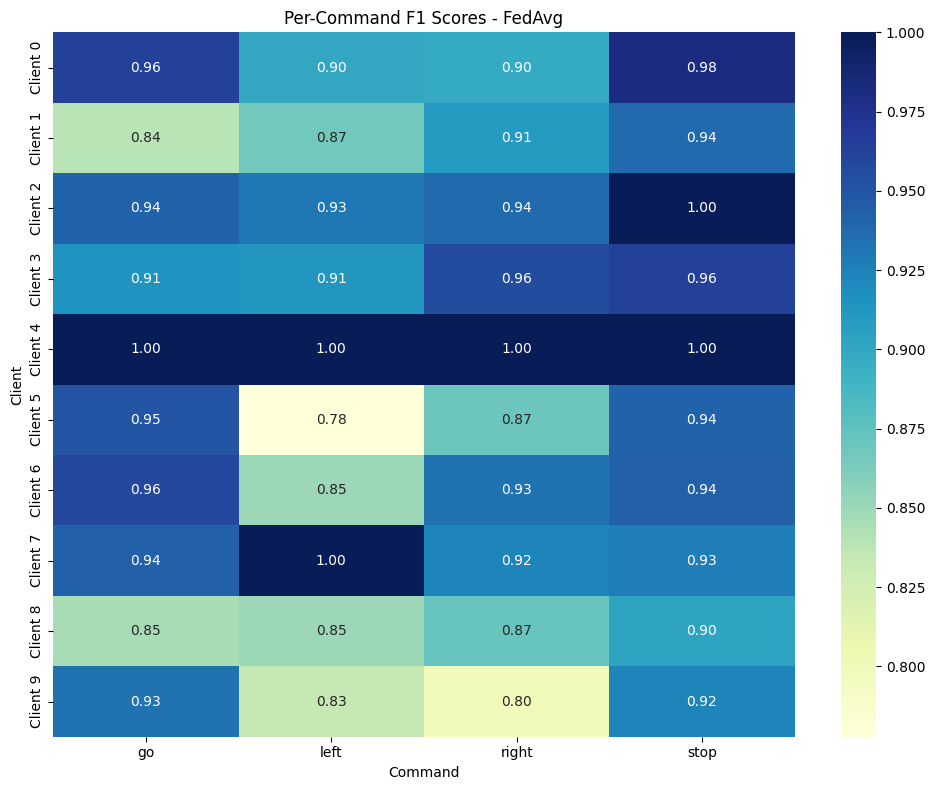


=== Running Personalized Federated Averaging ===
Model input shape: (13, 32, 1)
Model architecture created:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_58 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)


Training with pFedAvg...

--- pFedAvg Round 1/20 ---
Round 1 Averages -> Acc: 0.6423, Test Loss: 0.9147, Train Loss: 0.9239, Val Loss: 0.8327

--- pFedAvg Round 2/20 ---
Round 2 Averages -> Acc: 0.7591, Test Loss: 0.6659, Train Loss: 0.5372, Val Loss: 0.5502

--- pFedAvg Round 3/20 ---
Round 3 Averages -> Acc: 0.7755, Test Loss: 0.6196, Train Loss: 0.3602, Val Loss: 0.4570

--- pFedAvg Round 4/20 ---
Round 4 Averages -> Acc: 0.7911, Test Loss: 0.5751, Train Loss: 0.2525, Val Loss: 0.4259

--- pFedAvg Round 5/20 ---
Round 5 Averages -> Acc: 0.8212, Test Loss: 0.5459, Train Loss: 0.2092, Val Loss: 0.4119

--- pFedAvg Round 6/20 ---
Round 6 Averages -> Acc: 0.7934, Test Loss: 0.5478, Train Loss: 0.1685, Val Loss: 0.3898

--- pFedAvg Round 7/20 ---
Round 7 Averages -> Acc: 0.8155, Test Loss: 0.5064, Train Loss: 0.1396, Val Loss: 0.3975

--- pFedAvg Round 8/20 ---
Round 8 Averages -> Acc: 0.8271, Test Loss: 0.5300, Train Loss: 0.1203, Val Loss: 0.3859

--- pFedAvg Round 9/20 ---
Round 9 Av

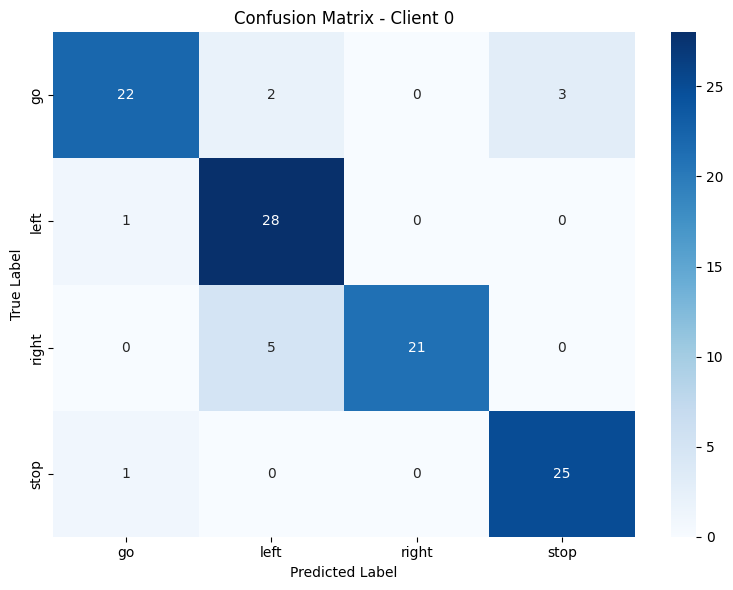

Client 0 Per-class performance:
  go: F1-score = 0.8627
  left: F1-score = 0.8750
  right: F1-score = 0.8936
  stop: F1-score = 0.9259
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


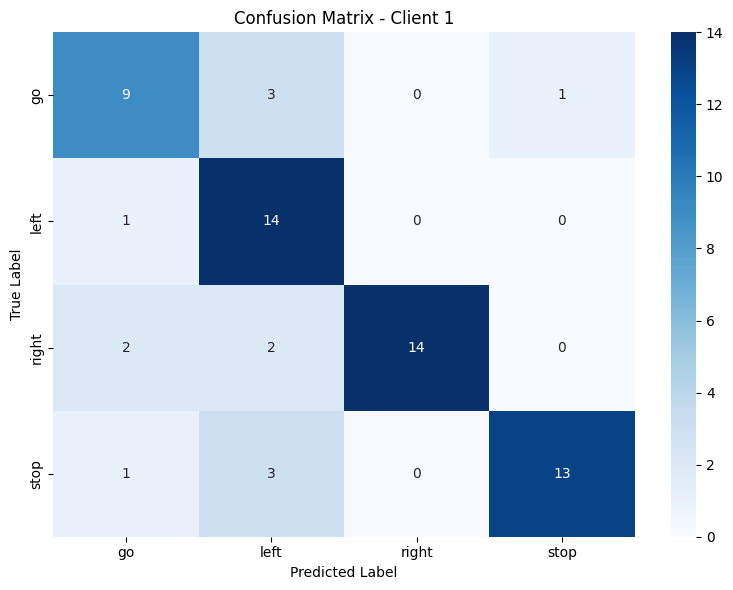

Client 1 Per-class performance:
  go: F1-score = 0.6923
  left: F1-score = 0.7568
  right: F1-score = 0.8750
  stop: F1-score = 0.8387
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


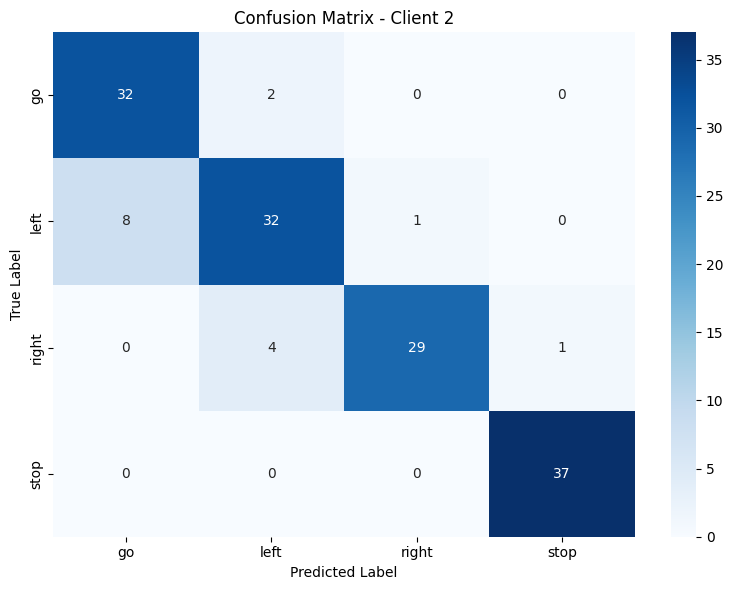

Client 2 Per-class performance:
  go: F1-score = 0.8649
  left: F1-score = 0.8101
  right: F1-score = 0.9062
  stop: F1-score = 0.9867
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


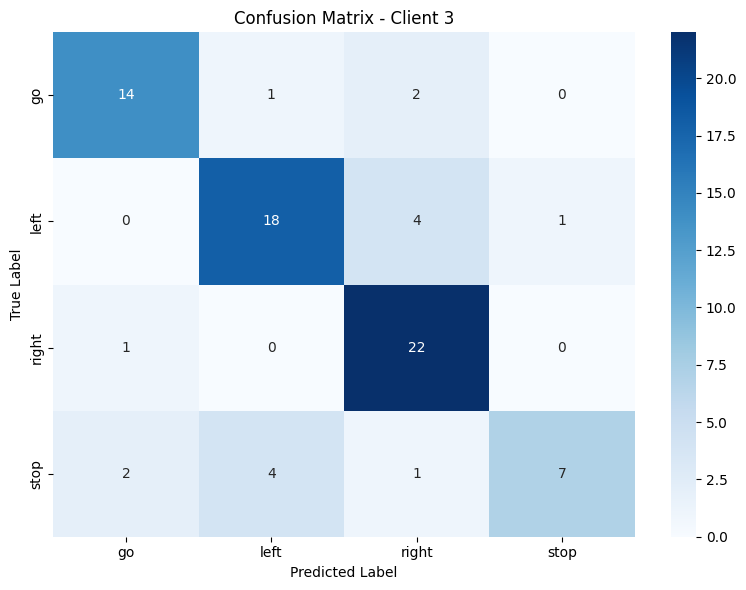

Client 3 Per-class performance:
  go: F1-score = 0.8235
  left: F1-score = 0.7826
  right: F1-score = 0.8462
  stop: F1-score = 0.6364
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


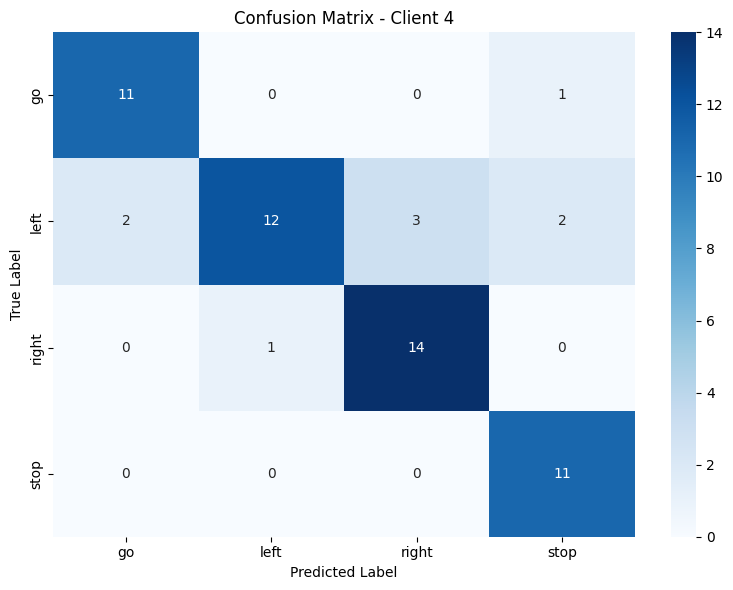

Client 4 Per-class performance:
  go: F1-score = 0.8800
  left: F1-score = 0.7500
  right: F1-score = 0.8750
  stop: F1-score = 0.8800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


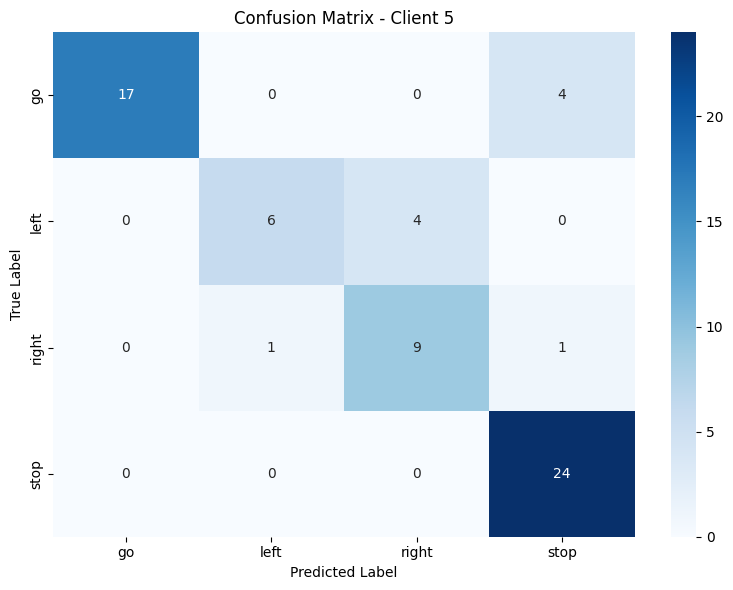

Client 5 Per-class performance:
  go: F1-score = 0.8947
  left: F1-score = 0.7059
  right: F1-score = 0.7500
  stop: F1-score = 0.9057
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


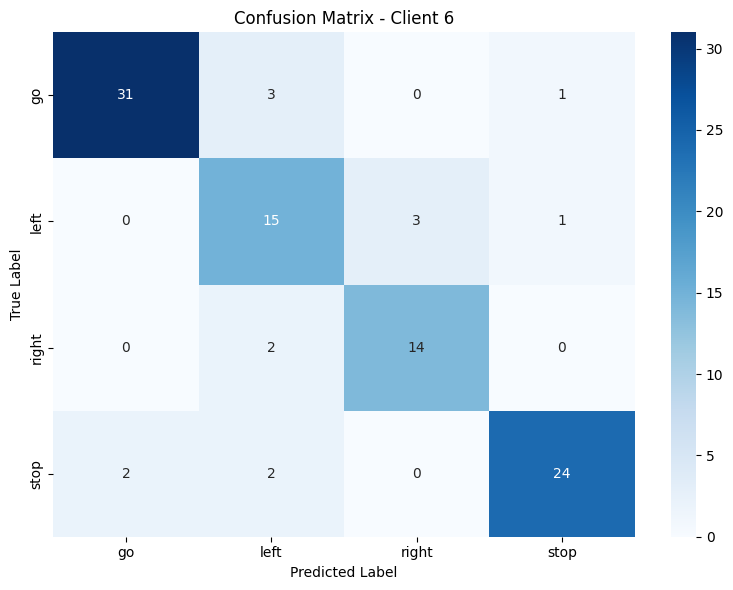

Client 6 Per-class performance:
  go: F1-score = 0.9118
  left: F1-score = 0.7317
  right: F1-score = 0.8485
  stop: F1-score = 0.8889
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


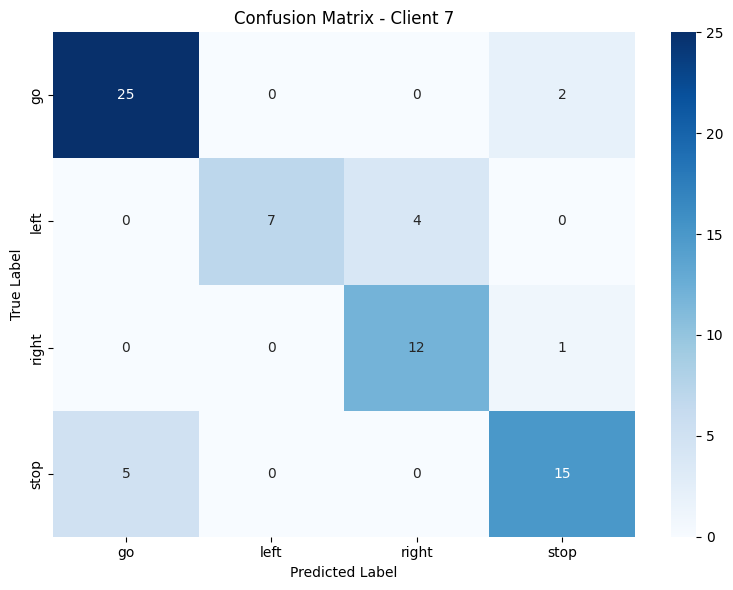

Client 7 Per-class performance:
  go: F1-score = 0.8772
  left: F1-score = 0.7778
  right: F1-score = 0.8276
  stop: F1-score = 0.7895
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


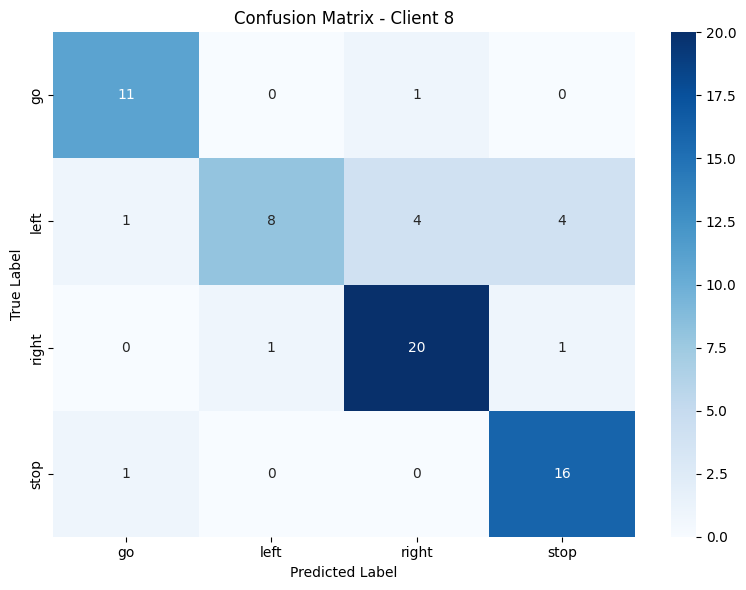

Client 8 Per-class performance:
  go: F1-score = 0.8800
  left: F1-score = 0.6154
  right: F1-score = 0.8511
  stop: F1-score = 0.8421
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


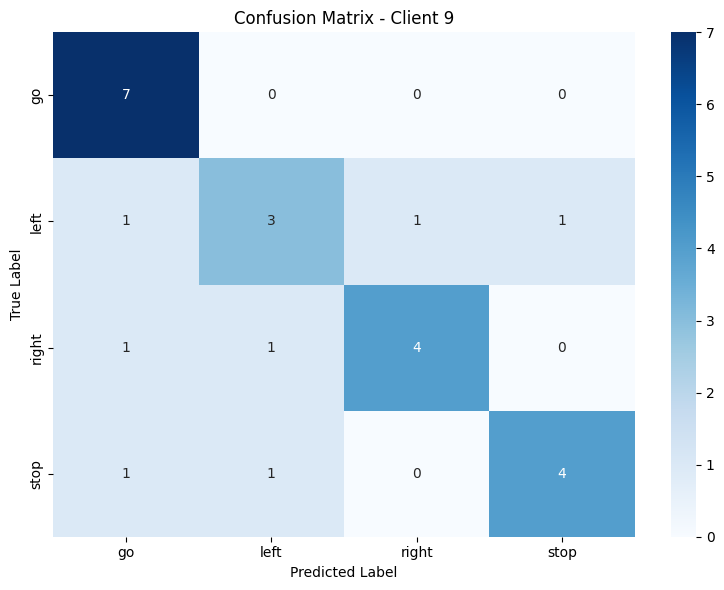

Client 9 Per-class performance:
  go: F1-score = 0.8235
  left: F1-score = 0.5455
  right: F1-score = 0.7273
  stop: F1-score = 0.7273
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


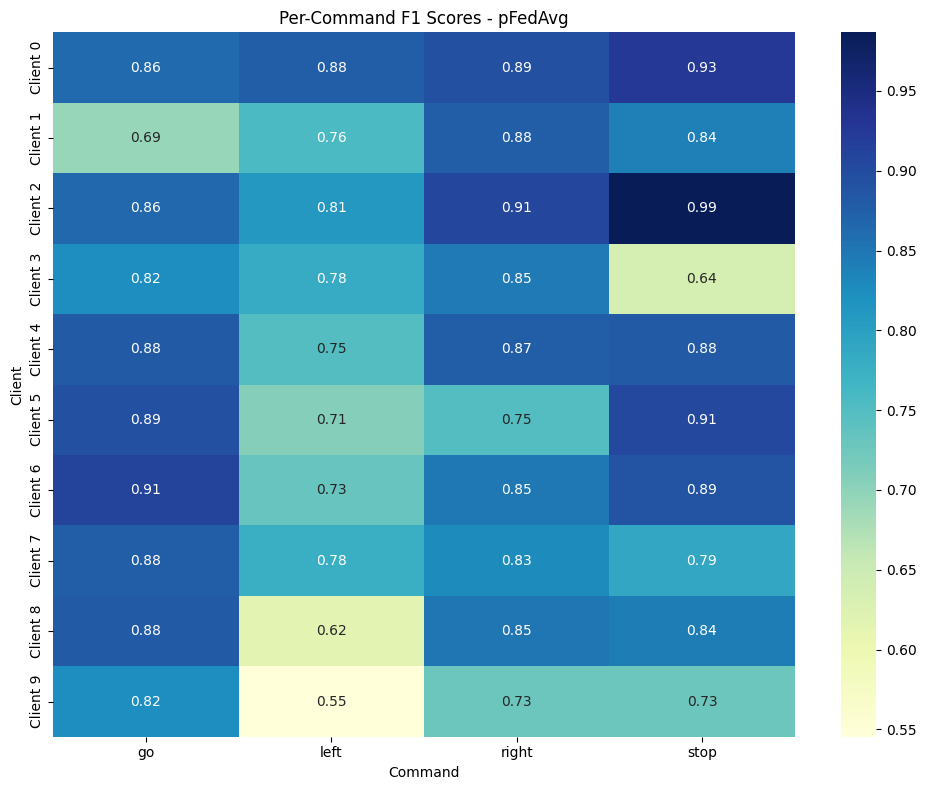


=== Running Alternative Personalized Federated Averaging ===
Model input shape: (13, 32, 1)
Model architecture created:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_62 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_64 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_68 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_34 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_70 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_35 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_36 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_74 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_37 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_76 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_38 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_78 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_39 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_80 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_81 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_40 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)


Training with pFedAvg V2 (alternative version)...

--- pFedAvg V2 Round 1/20 ---
Round 1 Averages -> Acc: 0.6380, Test Loss: 0.9807, Train Loss: 0.9123, Val Loss: 0.8237

--- pFedAvg V2 Round 2/20 ---
Round 2 Averages -> Acc: 0.7509, Test Loss: 0.7184, Train Loss: 0.5227, Val Loss: 0.5602

--- pFedAvg V2 Round 3/20 ---
Round 3 Averages -> Acc: 0.7784, Test Loss: 0.6082, Train Loss: 0.3439, Val Loss: 0.4737

--- pFedAvg V2 Round 4/20 ---
Round 4 Averages -> Acc: 0.7915, Test Loss: 0.5818, Train Loss: 0.2483, Val Loss: 0.4446

--- pFedAvg V2 Round 5/20 ---
Round 5 Averages -> Acc: 0.8055, Test Loss: 0.5494, Train Loss: 0.1848, Val Loss: 0.4237

--- pFedAvg V2 Round 6/20 ---
Round 6 Averages -> Acc: 0.8153, Test Loss: 0.5061, Train Loss: 0.1450, Val Loss: 0.4153

--- pFedAvg V2 Round 7/20 ---
Round 7 Averages -> Acc: 0.8189, Test Loss: 0.5099, Train Loss: 0.1176, Val Loss: 0.4072

--- pFedAvg V2 Round 8/20 ---
Round 8 Averages -> Acc: 0.8275, Test Loss: 0.5062, Train Loss: 0.1032, Val Lo

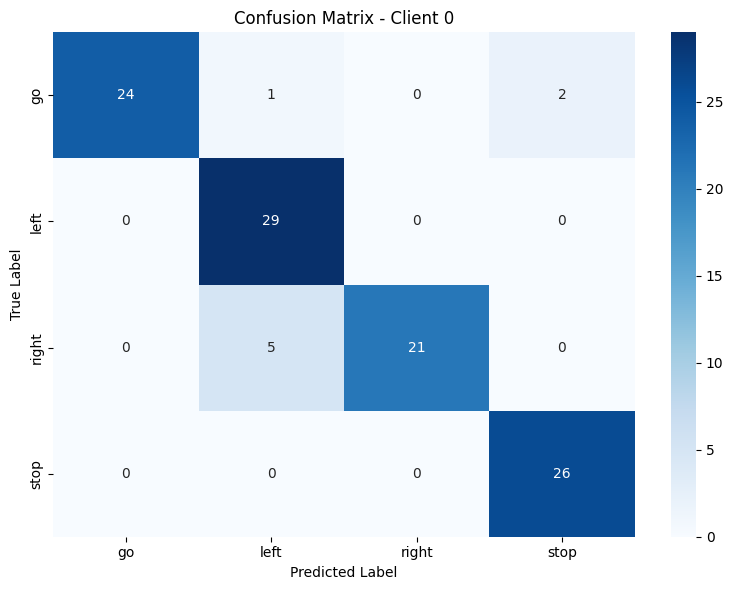

Client 0 Per-class performance:
  go: F1-score = 0.9412
  left: F1-score = 0.9062
  right: F1-score = 0.8936
  stop: F1-score = 0.9630
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


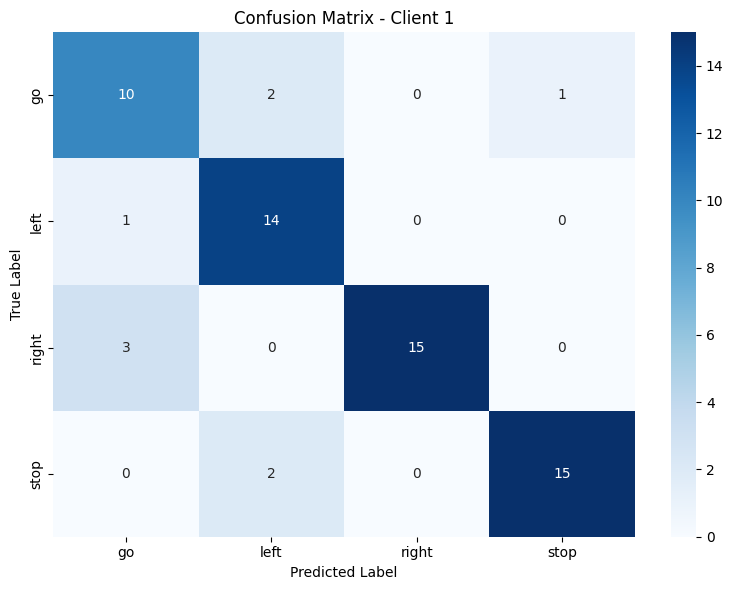

Client 1 Per-class performance:
  go: F1-score = 0.7407
  left: F1-score = 0.8485
  right: F1-score = 0.9091
  stop: F1-score = 0.9091
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


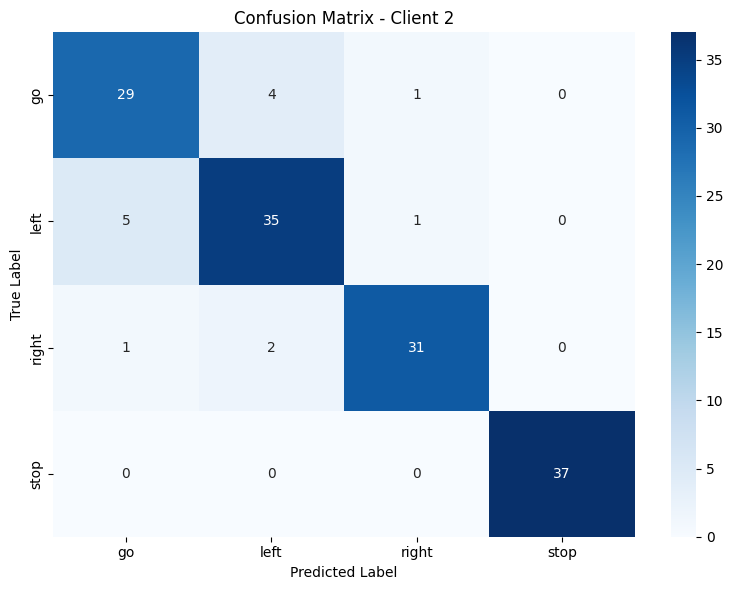

Client 2 Per-class performance:
  go: F1-score = 0.8406
  left: F1-score = 0.8537
  right: F1-score = 0.9254
  stop: F1-score = 1.0000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


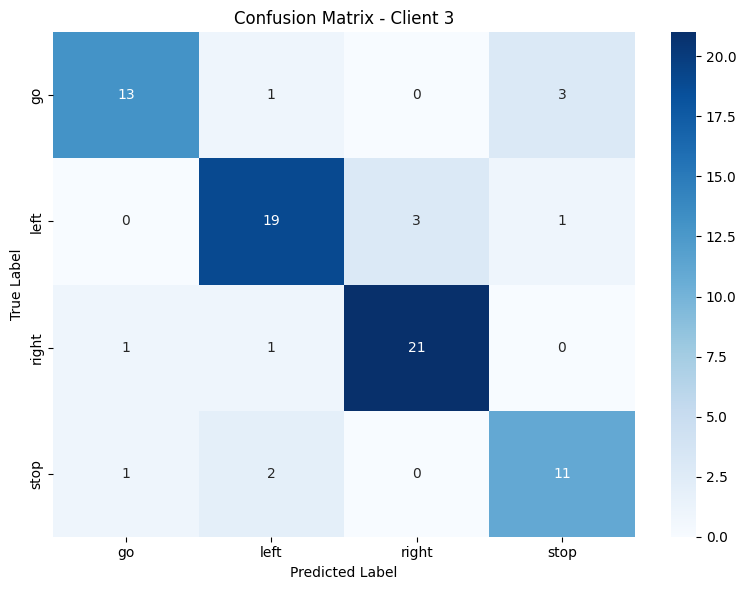

Client 3 Per-class performance:
  go: F1-score = 0.8125
  left: F1-score = 0.8261
  right: F1-score = 0.8936
  stop: F1-score = 0.7586
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


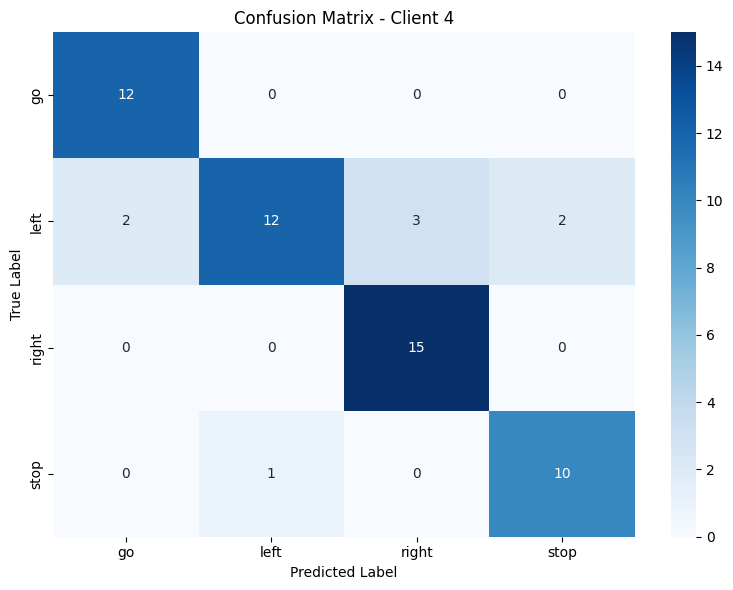

Client 4 Per-class performance:
  go: F1-score = 0.9231
  left: F1-score = 0.7500
  right: F1-score = 0.9091
  stop: F1-score = 0.8696
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


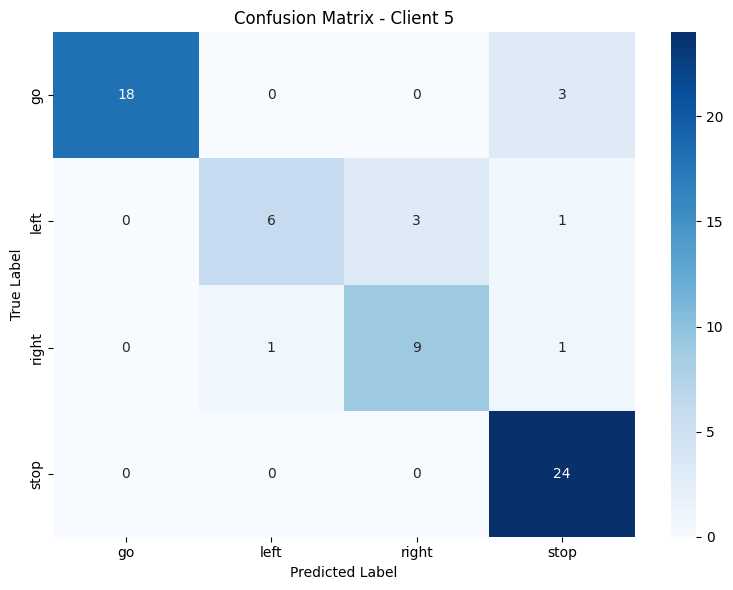

Client 5 Per-class performance:
  go: F1-score = 0.9231
  left: F1-score = 0.7059
  right: F1-score = 0.7826
  stop: F1-score = 0.9057
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


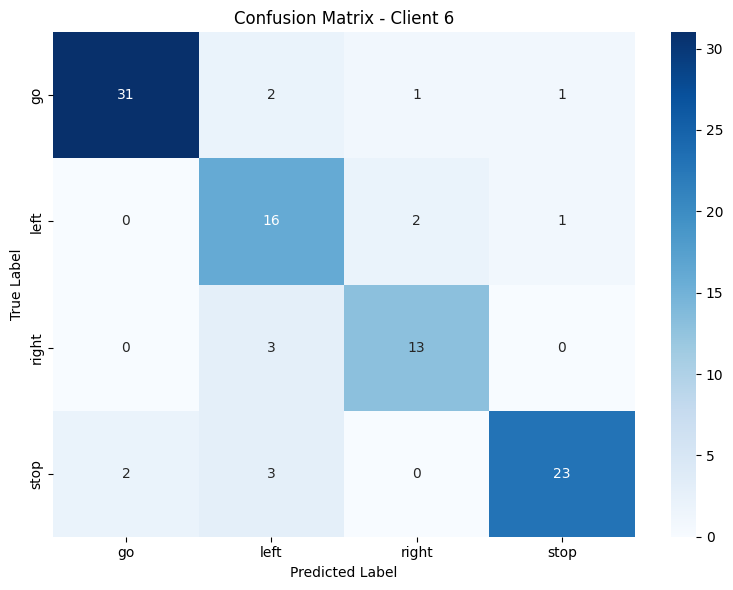

Client 6 Per-class performance:
  go: F1-score = 0.9118
  left: F1-score = 0.7442
  right: F1-score = 0.8125
  stop: F1-score = 0.8679
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


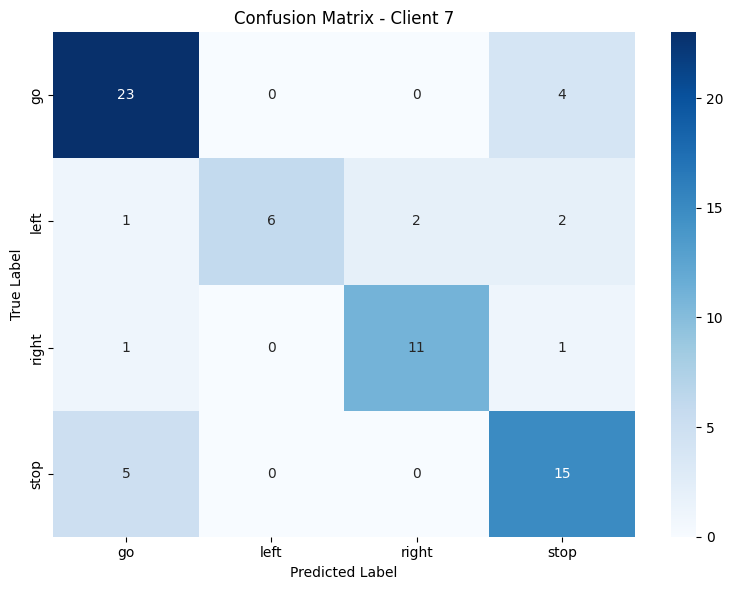

Client 7 Per-class performance:
  go: F1-score = 0.8070
  left: F1-score = 0.7059
  right: F1-score = 0.8462
  stop: F1-score = 0.7143
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


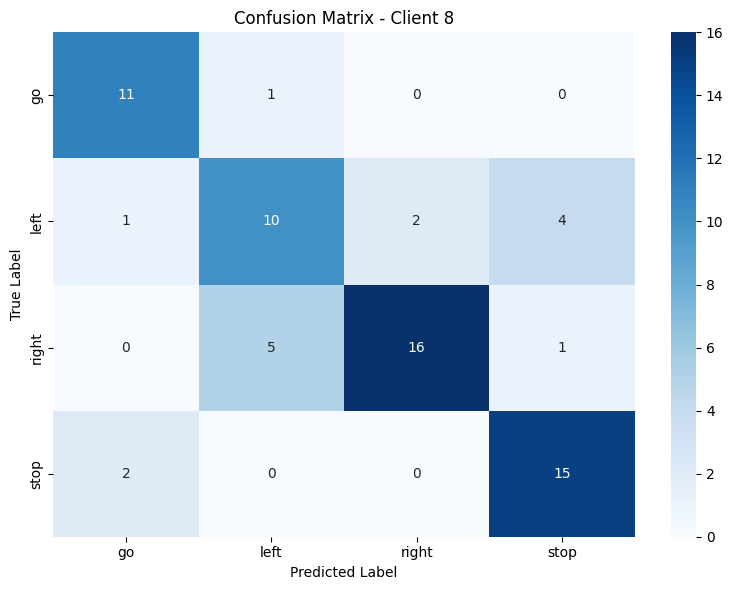

Client 8 Per-class performance:
  go: F1-score = 0.8462
  left: F1-score = 0.6061
  right: F1-score = 0.8000
  stop: F1-score = 0.8108
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


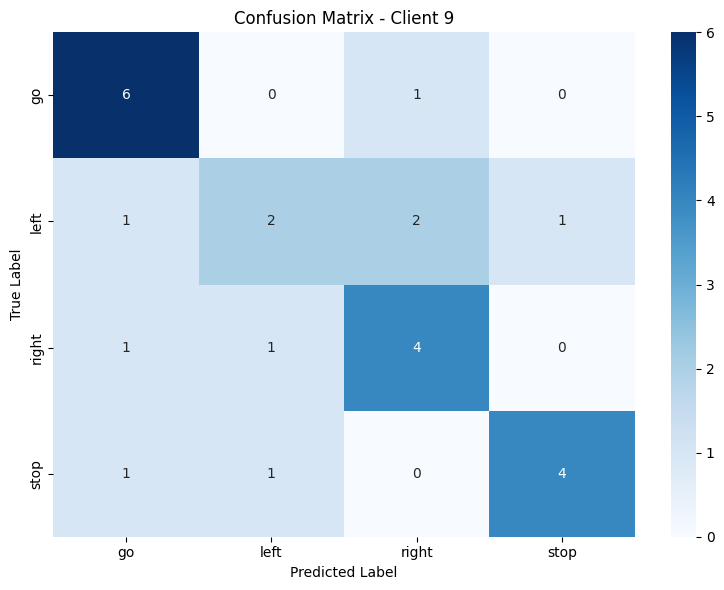

Client 9 Per-class performance:
  go: F1-score = 0.7500
  left: F1-score = 0.4000
  right: F1-score = 0.6154
  stop: F1-score = 0.7273
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


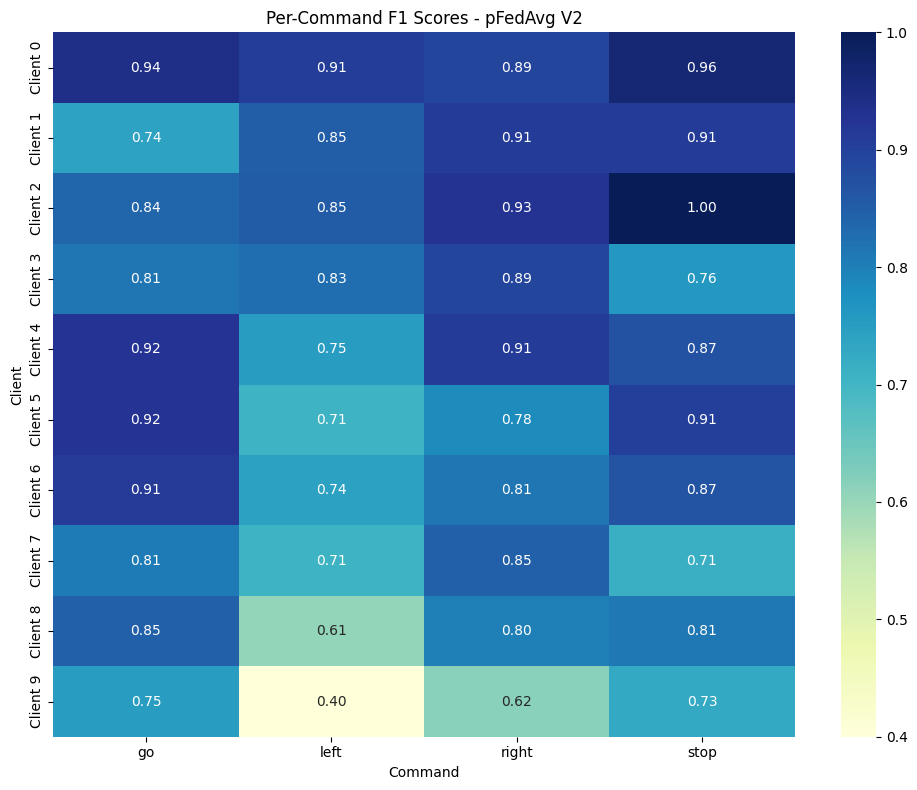


=== Running FedProx ===
Model input shape: (13, 32, 1)
Model architecture created:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_82 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_41 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_84 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_42 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_86 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_43 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_88 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_88 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_89 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_44 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_90 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_90 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_91 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_45 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_92 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_92 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_93 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_46 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_94 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_94 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_95 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_47 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_96 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_96 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_97 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_48 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_98 (Conv2D)              │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_98 (MaxPooling2D) │ (None, 6, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_99 (MaxPooling2D) │ (None, 3, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_49 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (13, 32, 1)
Model architecture created:


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_100 (Conv2D)             │ (None, 13, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_100               │ (None, 6, 16, 32)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 6, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_101               │ (None, 3, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_50 (Flatten)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,068 (844.02 KB)

 Trainable params: 216,068 (844.02 KB)

 Non-trainable params: 0 (0.00 B)

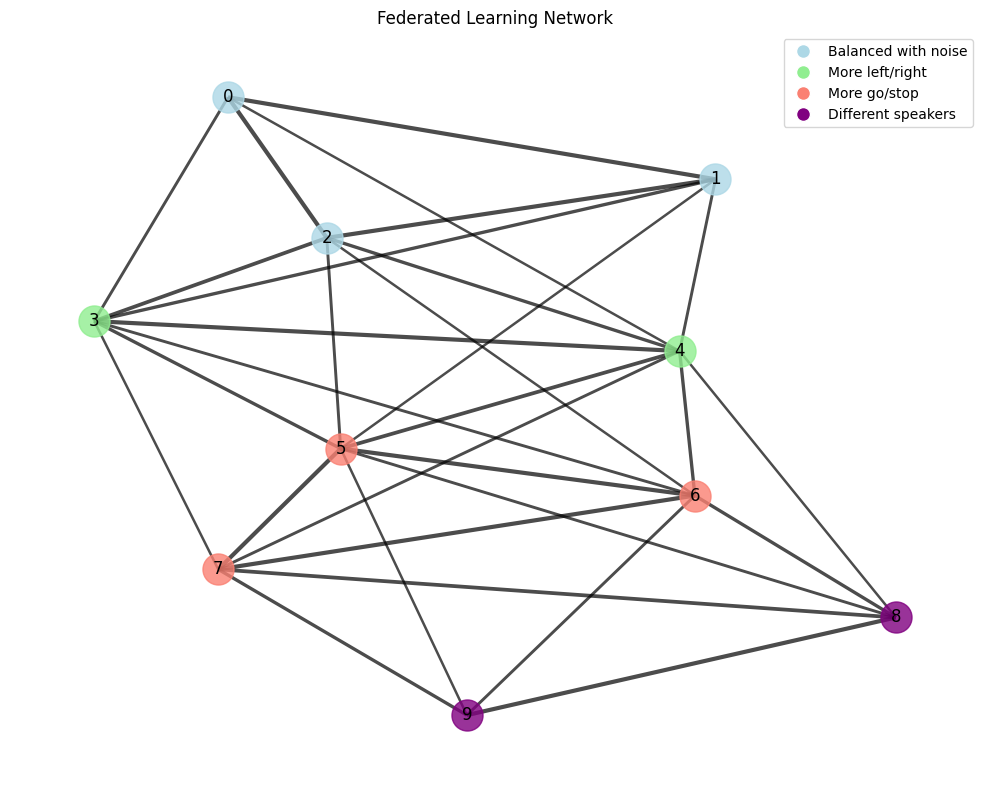


Training with FedProx...

--- FedProx Round 1/20 ---
Round 1 Averages -> Acc: 0.5290, Test Loss: 1.3265, Train Loss: 1.2392, Val Loss: 1.1844

--- FedProx Round 2/20 ---
Round 2 Averages -> Acc: 0.6675, Test Loss: 0.9449, Train Loss: 0.9160, Val Loss: 0.8733

--- FedProx Round 3/20 ---
Round 3 Averages -> Acc: 0.7292, Test Loss: 0.7669, Train Loss: 0.6716, Val Loss: 0.6824

--- FedProx Round 4/20 ---
Round 4 Averages -> Acc: 0.7840, Test Loss: 0.6316, Train Loss: 0.5058, Val Loss: 0.5535

--- FedProx Round 5/20 ---
Round 5 Averages -> Acc: 0.8149, Test Loss: 0.5526, Train Loss: 0.3736, Val Loss: 0.4569

--- FedProx Round 6/20 ---
Round 6 Averages -> Acc: 0.8389, Test Loss: 0.4996, Train Loss: 0.3039, Val Loss: 0.3987

--- FedProx Round 7/20 ---
Round 7 Averages -> Acc: 0.8608, Test Loss: 0.4709, Train Loss: 0.2534, Val Loss: 0.3608

--- FedProx Round 8/20 ---
Round 8 Averages -> Acc: 0.8795, Test Loss: 0.4429, Train Loss: 0.2170, Val Loss: 0.3234

--- FedProx Round 9/20 ---
Round 9 Av

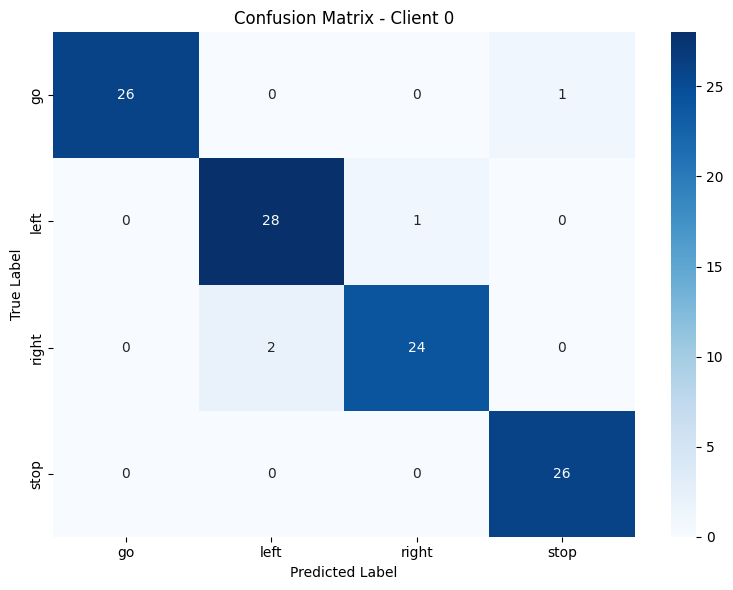

Client 0 Per-class performance:
  go: F1-score = 0.9811
  left: F1-score = 0.9492
  right: F1-score = 0.9412
  stop: F1-score = 0.9811
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


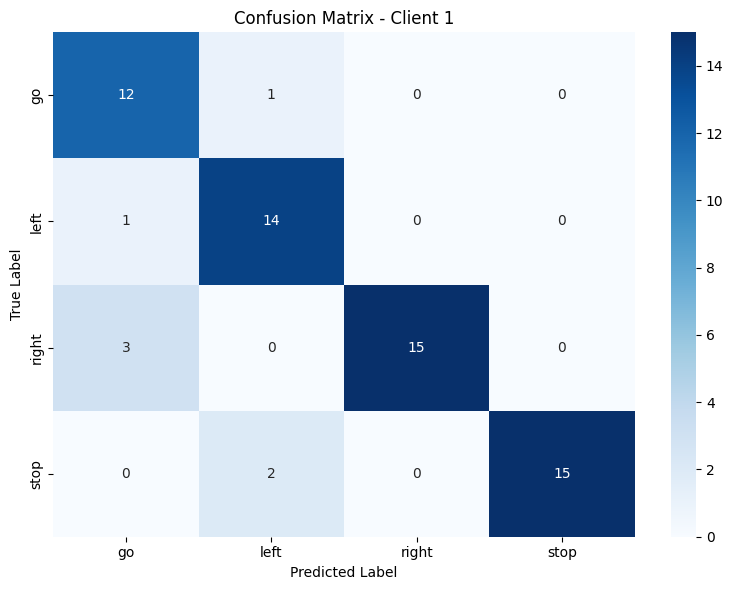

Client 1 Per-class performance:
  go: F1-score = 0.8276
  left: F1-score = 0.8750
  right: F1-score = 0.9091
  stop: F1-score = 0.9375
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


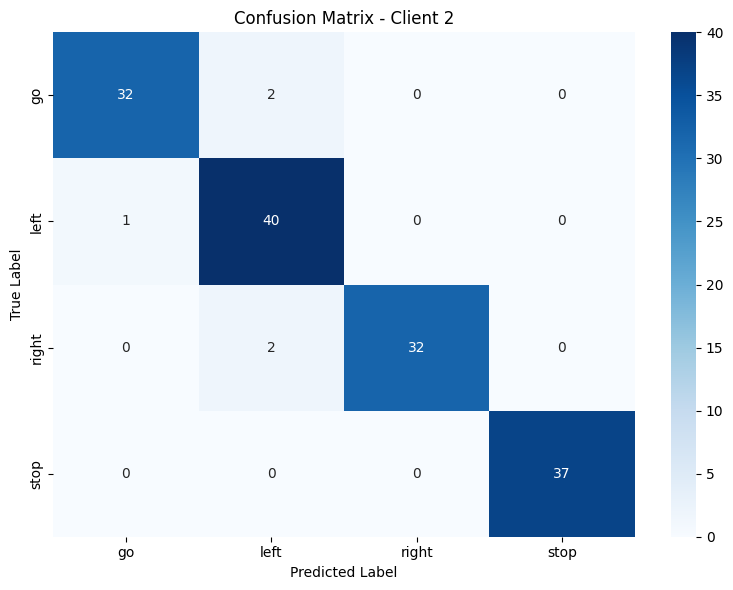

Client 2 Per-class performance:
  go: F1-score = 0.9552
  left: F1-score = 0.9412
  right: F1-score = 0.9697
  stop: F1-score = 1.0000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


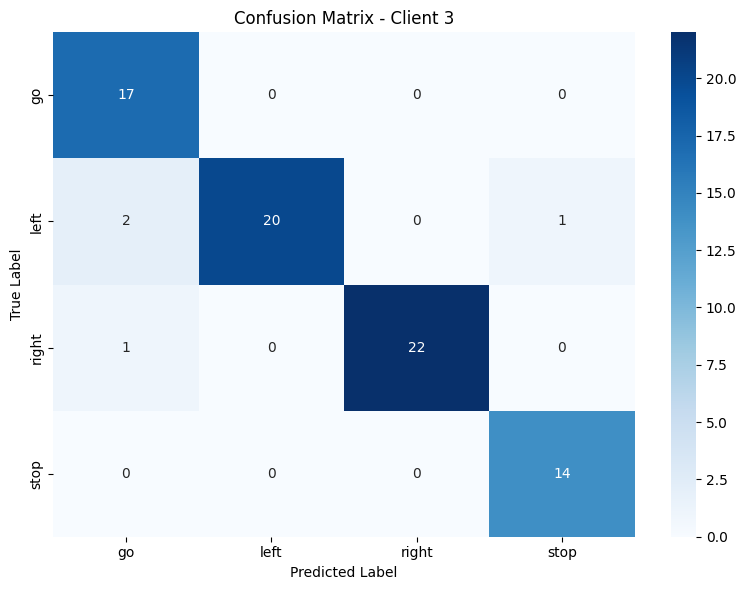

Client 3 Per-class performance:
  go: F1-score = 0.9189
  left: F1-score = 0.9302
  right: F1-score = 0.9778
  stop: F1-score = 0.9655
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


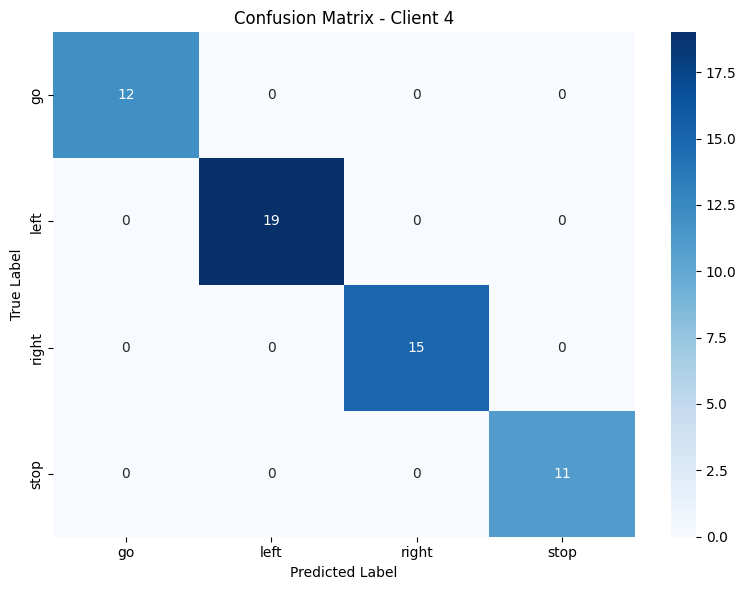

Client 4 Per-class performance:
  go: F1-score = 1.0000
  left: F1-score = 1.0000
  right: F1-score = 1.0000
  stop: F1-score = 1.0000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


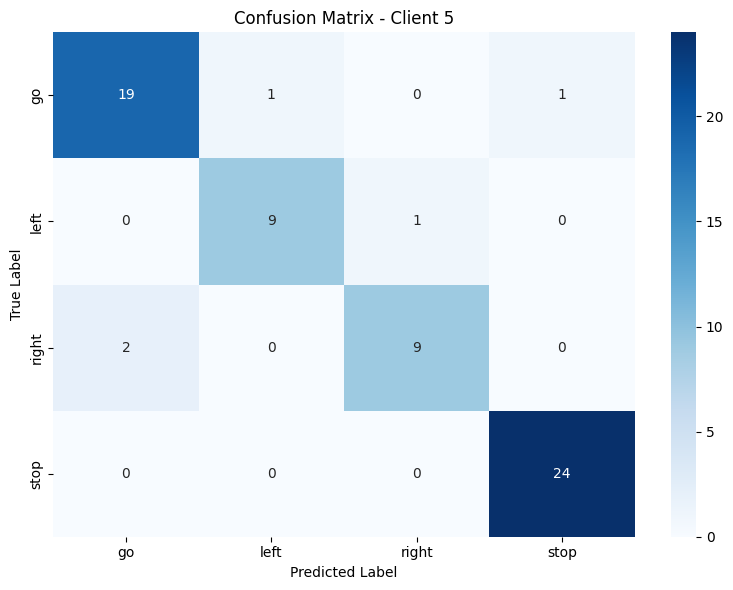

Client 5 Per-class performance:
  go: F1-score = 0.9048
  left: F1-score = 0.9000
  right: F1-score = 0.8571
  stop: F1-score = 0.9796
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


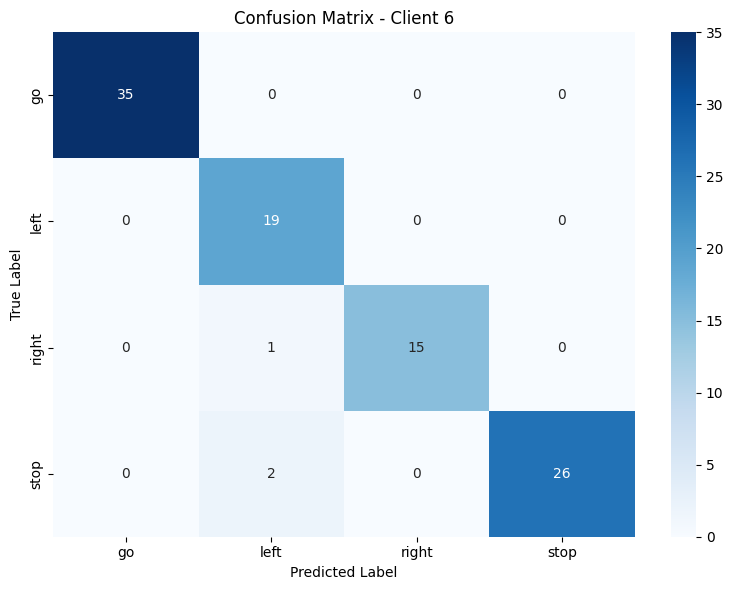

Client 6 Per-class performance:
  go: F1-score = 1.0000
  left: F1-score = 0.9268
  right: F1-score = 0.9677
  stop: F1-score = 0.9630
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


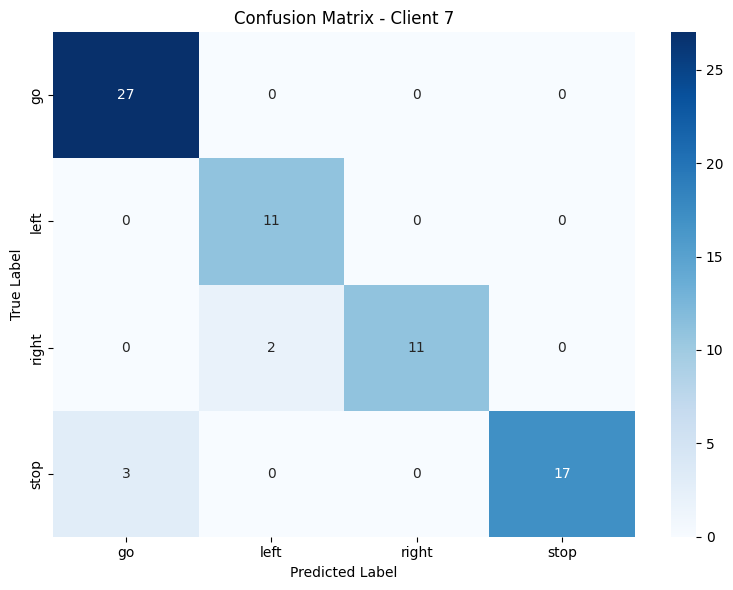

Client 7 Per-class performance:
  go: F1-score = 0.9474
  left: F1-score = 0.9167
  right: F1-score = 0.9167
  stop: F1-score = 0.9189
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


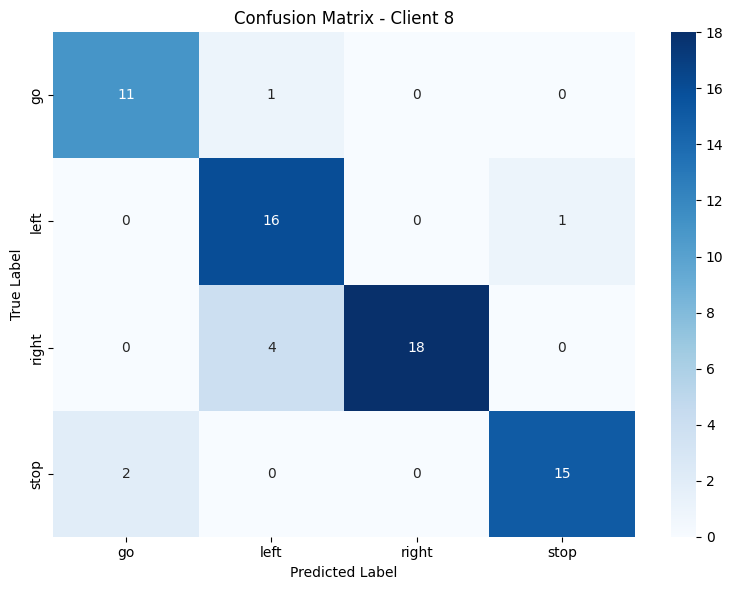

Client 8 Per-class performance:
  go: F1-score = 0.8800
  left: F1-score = 0.8421
  right: F1-score = 0.9000
  stop: F1-score = 0.9091
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


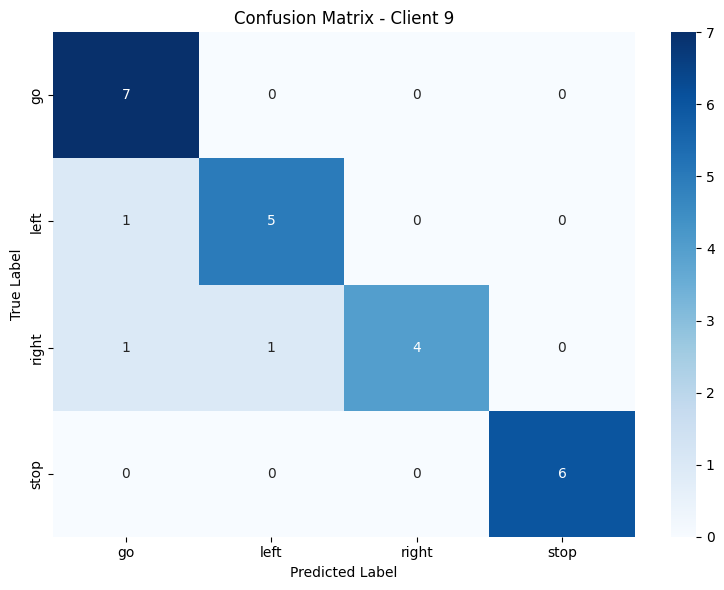

Client 9 Per-class performance:
  go: F1-score = 0.8750
  left: F1-score = 0.8333
  right: F1-score = 0.8000
  stop: F1-score = 1.0000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


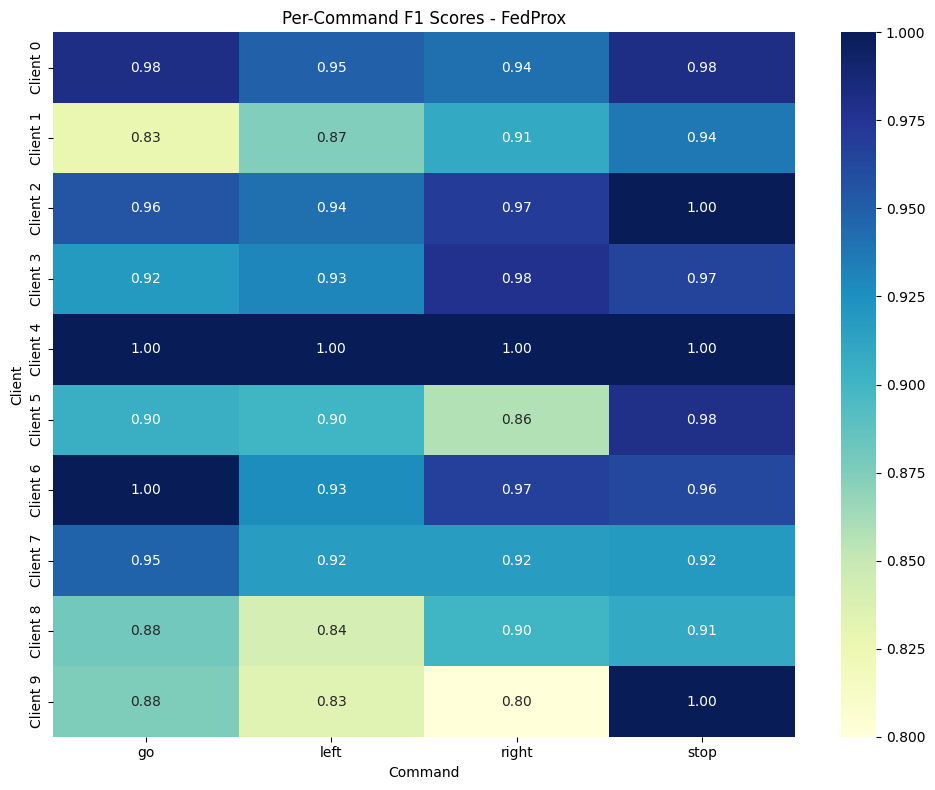


Experiment finished. Now generating reports...


=== Generating Main Comparison Results ===


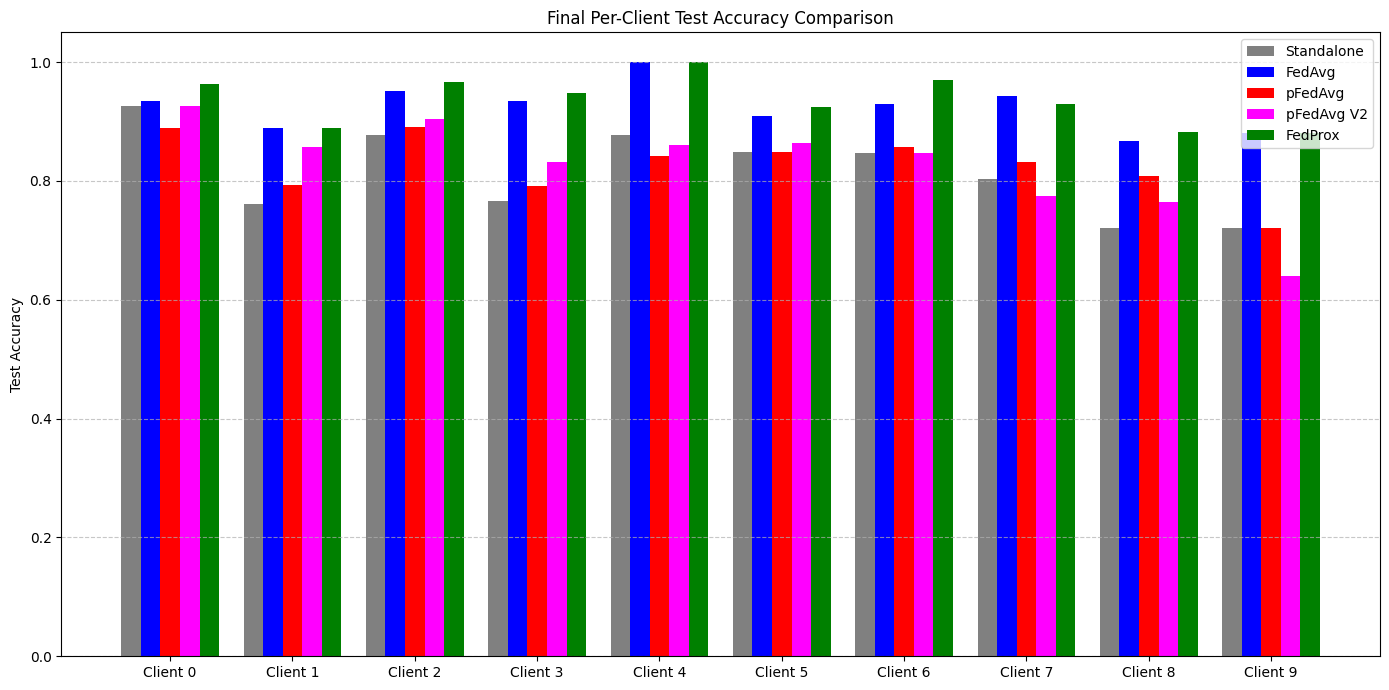

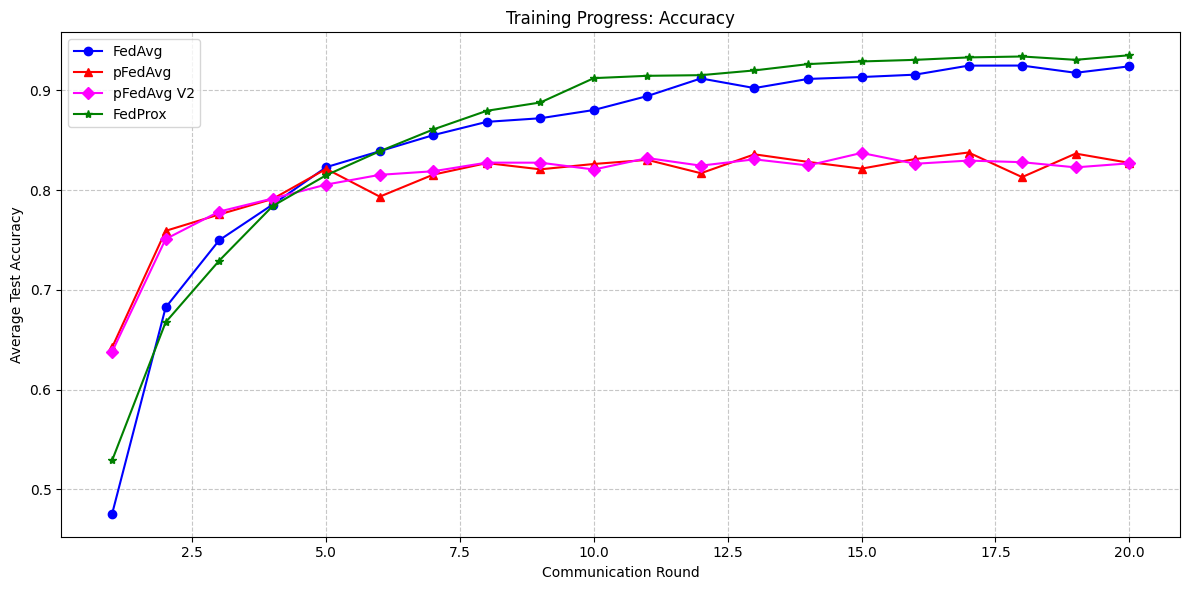

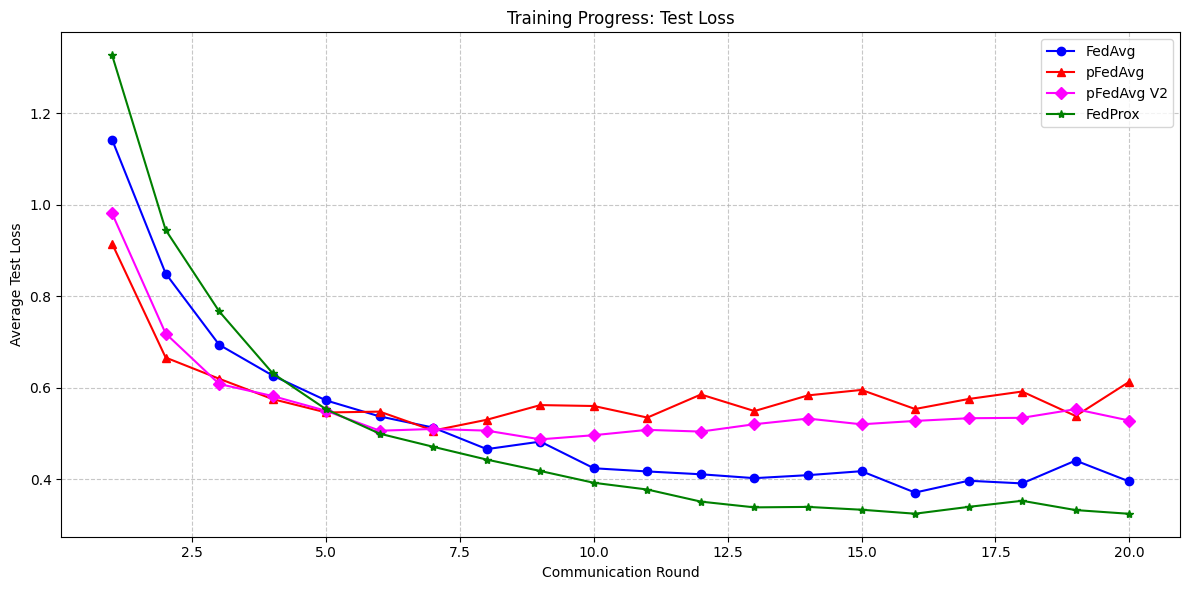

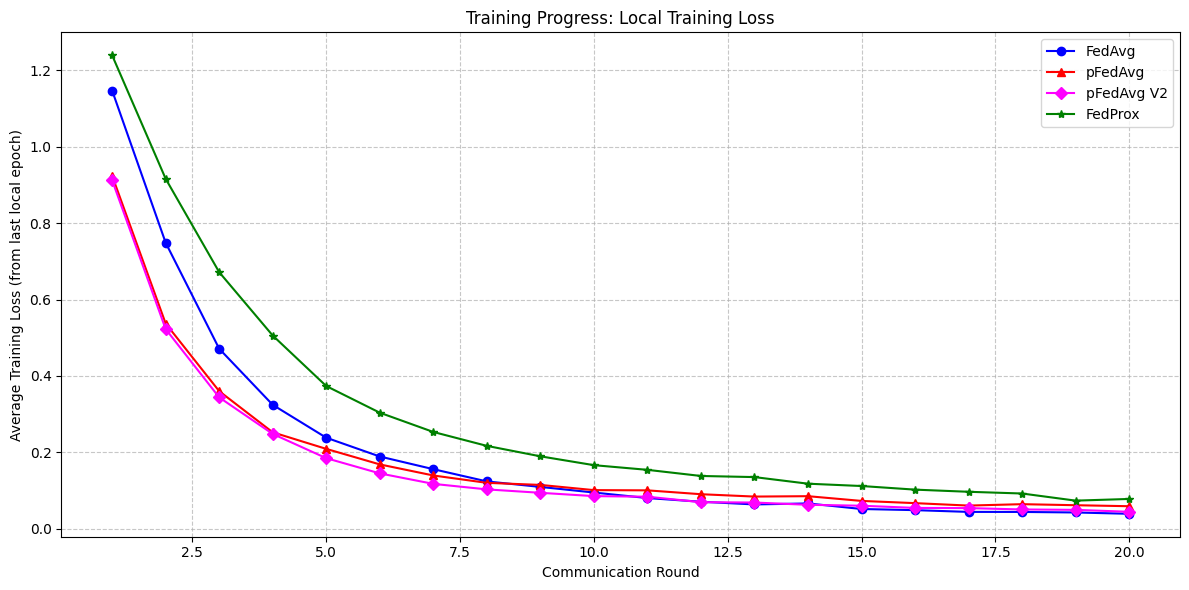

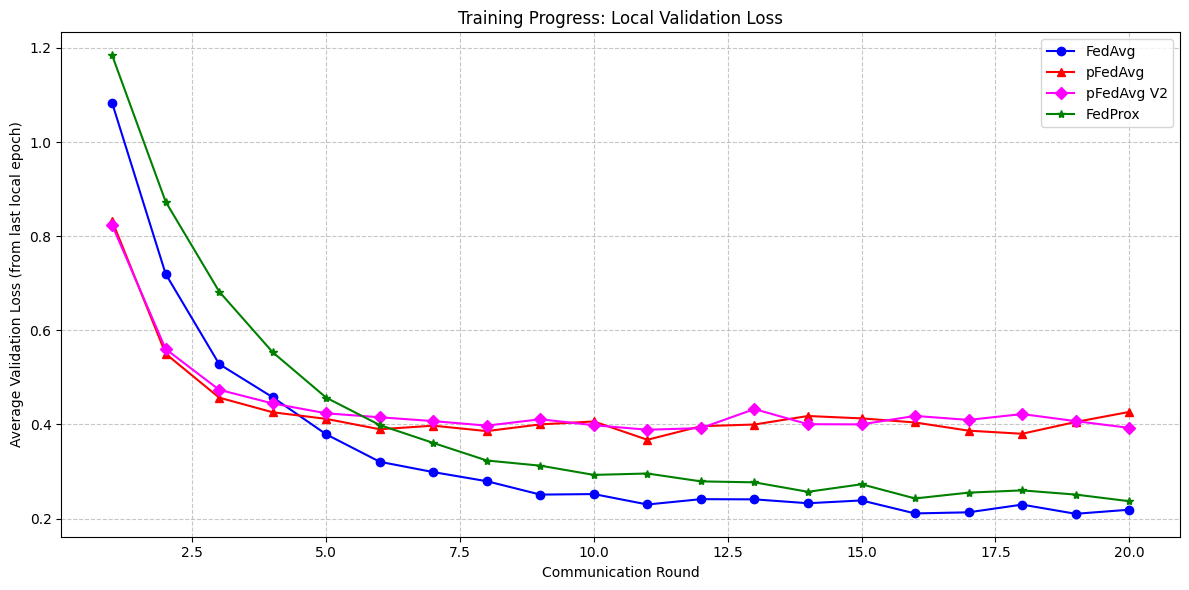


=== Final Average Results ===
 Algorithm  Avg Accuracy  Avg Test Loss
Standalone        0.8147         0.6432
    FedAvg        0.9240         0.3952
   pFedAvg        0.8273         0.6129
pFedAvg V2        0.8268         0.5283
   FedProx        0.9351         0.3245

=== Detailed Per-Client Results ===
  Client  Standalone Acc  Standalone Loss  FedAvg Acc  FedAvg Loss  pFedAvg Acc  pFedAvg Loss  pFedAvg V2 Acc  pFedAvg V2 Loss  FedProx Acc  FedProx Loss
Client 0          0.9259           0.4164      0.9352       0.3153       0.8889        0.3507          0.9259           0.3202       0.9630        0.1306
Client 1          0.7619           0.7295      0.8889       0.8052       0.7937        0.6800          0.8571           0.4853       0.8889        0.5253
Client 2          0.8767           0.5227      0.9521       0.1618       0.8904        0.3745          0.9041           0.2526       0.9658        0.0803
Client 3          0.7662           0.6345      0.9351       0.1664       0.7

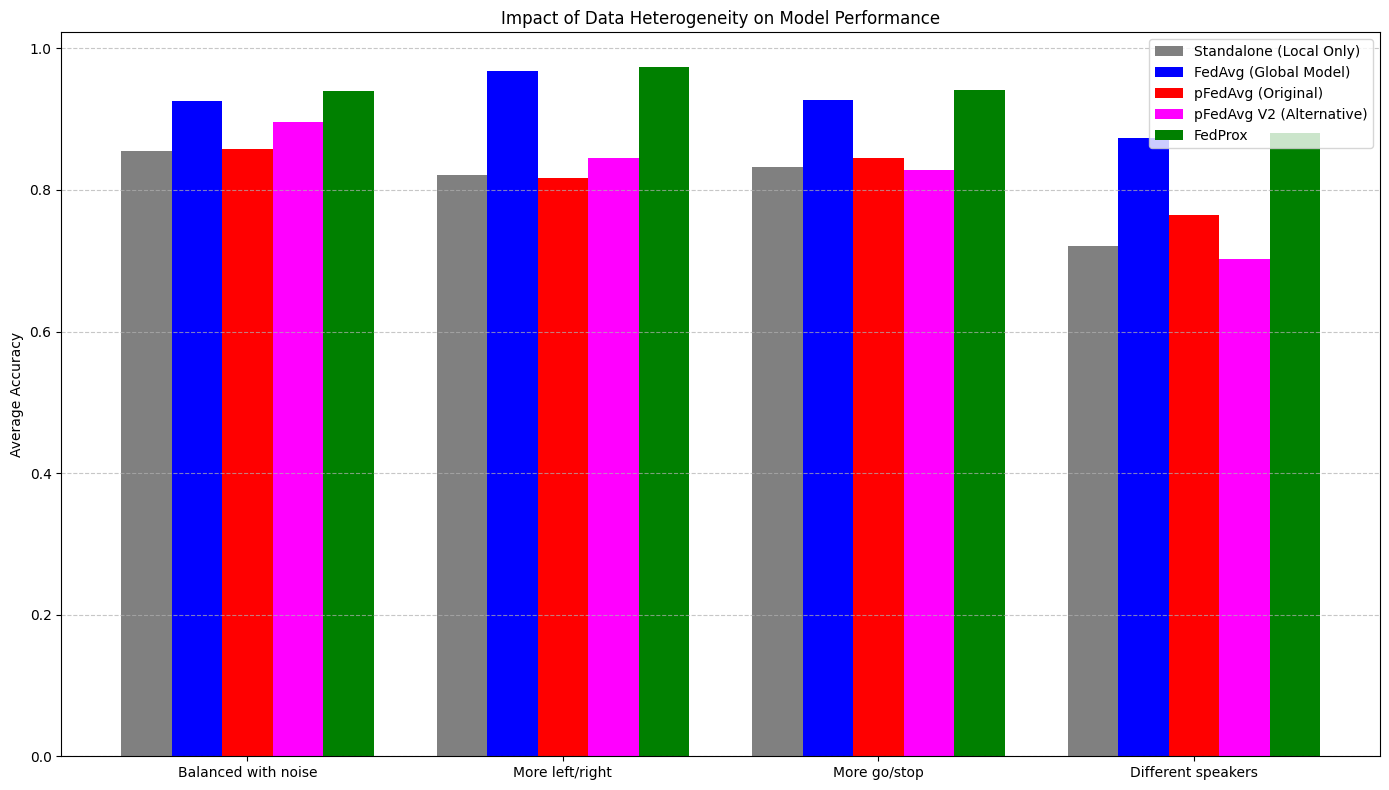


=== Impact of Data Heterogeneity ===

Balanced with noise:
  Standalone (Local Only): 0.8548
  FedAvg (Global Model): 0.9254
  pFedAvg (Original): 0.8577
  pFedAvg V2 (Alternative): 0.8957
  FedProx: 0.9392

  Improvements over Standalone:
    FedAvg (Global Model): 0.0705 (7.1%)
    pFedAvg (Original): 0.0028 (0.3%)
    pFedAvg V2 (Alternative): 0.0409 (4.1%)
    FedProx: 0.0844 (8.4%)

  Improvements over FedAvg:
    pFedAvg (Original): -0.0677 (-6.8%)
    pFedAvg V2 (Alternative): -0.0297 (-3.0%)
    FedProx: 0.0138 (1.4%)

More left/right:
  Standalone (Local Only): 0.8217
  FedAvg (Global Model): 0.9675
  pFedAvg (Original): 0.8172
  pFedAvg V2 (Alternative): 0.8454
  FedProx: 0.9740

  Improvements over Standalone:
    FedAvg (Global Model): 0.1458 (14.6%)
    pFedAvg (Original): -0.0046 (-0.5%)
    pFedAvg V2 (Alternative): 0.0237 (2.4%)
    FedProx: 0.1523 (15.2%)

  Improvements over FedAvg:
    pFedAvg (Original): -0.1504 (-15.0%)
    pFedAvg V2 (Alternative): -0.1221 (-12.2

In [22]:
# Cell 19: Run experiment with modified parameters for Kaggle
# Example of running the full experiment (uncomment when ready)
# Reduced parameters for faster execution on Kaggle
# results = run_full_experiment(
#     DATA_DIR,
#     n_clients=10,
#     standalone_epochs=10,  # Reduced from 20
#     fl_rounds=10,          # Reduced from 20
#     local_epochs=5,        # Reduced from 5
#     lambda_reg=0.1
# )
# Run just FedAvg and FedProx
# results = run_experiment(
#     DATA_DIR,
#     algorithms=['fedavg', 'fedprox'],
#     n_clients=10,
#     standalone_epochs=10,
#     fl_rounds=10,
#     local_epochs=5,
#     mu=0.01
# )

# Run all algorithms
# results = run_experiment(
#     DATA_DIR,
#     n_clients=10,
#     standalone_epochs=10,
#     fl_rounds=10,
#     local_epochs=5,
#     lambda_reg=0.1,
#     lambda_reg_v2=0.1,
#     mu=0.01
# )

# REPLACE YOUR FINAL CELL WITH THIS CODE

# 1. Run the entire experiment and get the rich 'results' dictionary
print("Starting the full experiment...")
results = run_experiment(
    DATA_DIR,
    n_clients=10,
    standalone_epochs=25,
    fl_rounds=20,
    local_epochs=5,
    lambda_reg=0.1,
    lambda_reg_v2=0.1,
    mu=0.01
)
print("\nExperiment finished. Now generating reports...")


# 2. Call the main comparison function to generate plots and tables
#    This is the step that was missing.
if 'results' in locals() and results:
    print("\n\n=== Generating Main Comparison Results ===")
    compare_selected_results(results)


# 3. Call the heterogeneity analysis function
if 'results' in locals() and results:
    print("\n\n=== Generating Heterogeneity Impact Analysis ===")
    analyze_heterogeneity_impact(results)

print("\n\nScript finished.")

# # Run just the original pFedAvg and alternative pFedAvg V2
# results = run_experiment(
#     DATA_DIR,
#     algorithms=['pfedavg', 'pfedavg_v2'],
#     n_clients=10,
#     fl_rounds=10,
#     local_epochs=5,
#     alpha=0.1,
#     lambda_reg=0.1
# )

In [23]:

# print("Attempting to re-run comparison with existing results...")
# if 'results' in locals() and results:
#     try:
#         compare_selected_results(results)
#         print("Comparison completed successfully.")
#     except Exception as e:
#         print(f"An error occurred during comparison: {e}")
#         # You might want to print the results variable here for debugging
#         # print(results)
# else:
#     print("Error: The 'results' variable was not found or is empty.")
#     print("You may need to re-run the main experiment cell.")

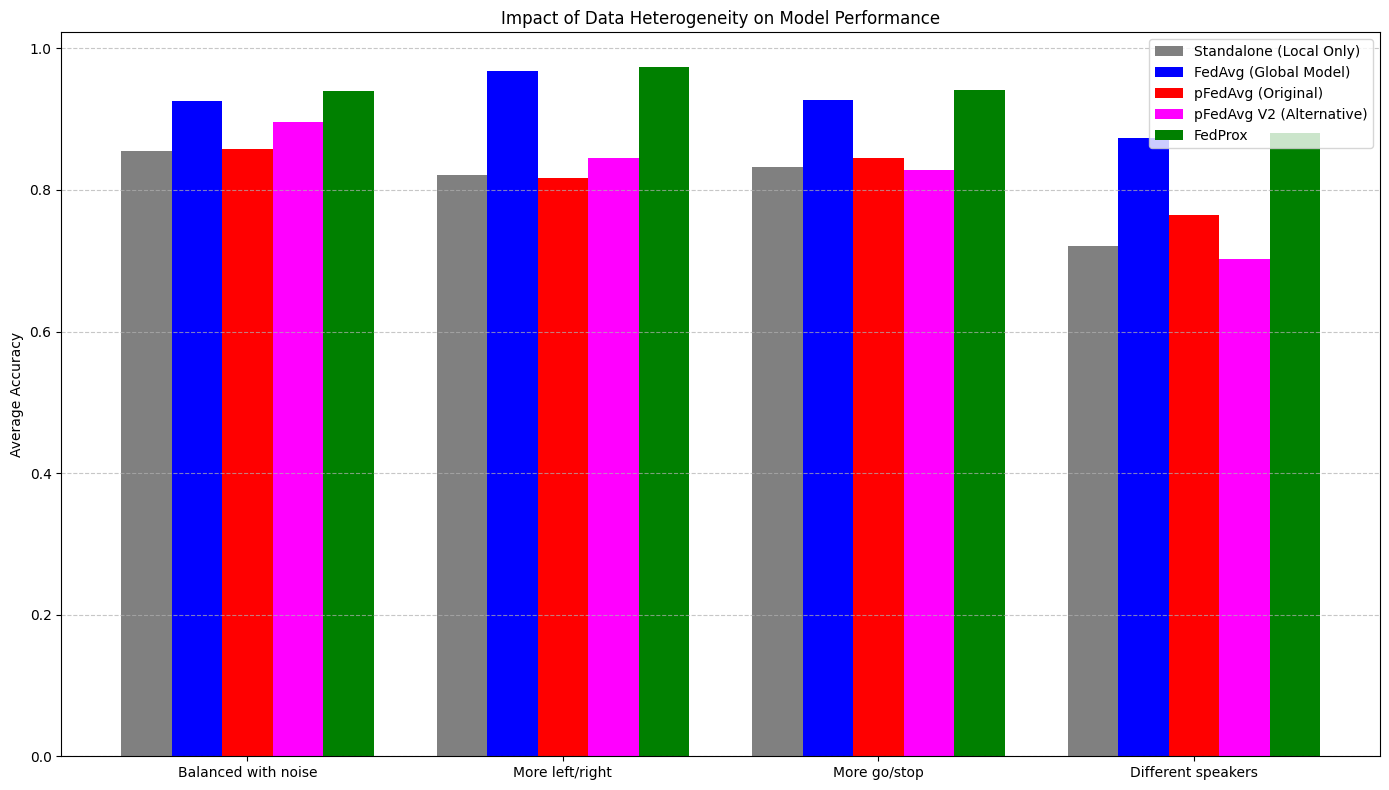


=== Impact of Data Heterogeneity ===

Balanced with noise:
  Standalone (Local Only): 0.8548
  FedAvg (Global Model): 0.9254
  pFedAvg (Original): 0.8577
  pFedAvg V2 (Alternative): 0.8957
  FedProx: 0.9392

  Improvements over Standalone:
    FedAvg (Global Model): 0.0705 (7.1%)
    pFedAvg (Original): 0.0028 (0.3%)
    pFedAvg V2 (Alternative): 0.0409 (4.1%)
    FedProx: 0.0844 (8.4%)

  Improvements over FedAvg:
    pFedAvg (Original): -0.0677 (-6.8%)
    pFedAvg V2 (Alternative): -0.0297 (-3.0%)
    FedProx: 0.0138 (1.4%)

More left/right:
  Standalone (Local Only): 0.8217
  FedAvg (Global Model): 0.9675
  pFedAvg (Original): 0.8172
  pFedAvg V2 (Alternative): 0.8454
  FedProx: 0.9740

  Improvements over Standalone:
    FedAvg (Global Model): 0.1458 (14.6%)
    pFedAvg (Original): -0.0046 (-0.5%)
    pFedAvg V2 (Alternative): 0.0237 (2.4%)
    FedProx: 0.1523 (15.2%)

  Improvements over FedAvg:
    pFedAvg (Original): -0.1504 (-15.0%)
    pFedAvg V2 (Alternative): -0.1221 (-12.2

In [24]:
analyze_heterogeneity_impact(results)